## Car Price Prediction Microservice

### Throughout this note i will walk you through the steps i've taken to extract and analyze features and then prepare them for the ml algorithms, and then i we would see which ml model performs the best, and then use that in the microservice to predict car price from incoming features.

##### First let's import the necessary libraries

In [1]:
from lxml import html
import os
import re
import pandas as pd
import math 
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pickle


pd.set_option('display.max_columns', None)

#### Feature Extraction :

##### Here i would enter the folder name that contains the pages which we would extract the features from to train our model with, this would result in a list of paths for each page

In [2]:
folder_path = "../data"
paths = os.listdir(folder_path)

##### Now i would want to iterate over the paths array and extract the features from the pages which are in html format, because the pages are in html format extracting the features won't be a pain since the pages are formatted in a way where every feature has its own place holder, so to find those place holders let's look at one of the pages 

In [3]:
file = open(folder_path + "/" + paths[0], 'r',encoding="utf-8")
data = file.read()
print(data)

<!DOCTYPE html>
<html lang="ar">

<head>
  <title>كيا اوبتيما موديل سنة 2014 | شو بدك من فلسطين؟</title>
<meta name="description" content="السيارة بحالة ممتازة، جميع الاضافات وفتحة سقف بانوراما لون أسود. السعر 100 ألف شيكل، يشمل تأمين شامل 9 شهور وترخيص 9 شهور.">
<link rel="canonical" href="https://shobiddak.com/cars?q[car_model_id_eq]=20&amp;q[car_sub_model_id_eq]=72">
<meta property="og:site_name" content="شو بدك من فلسطين؟">
<meta property="og:title" content="كيا اوبتيما موديل سنة 2014">
<meta property="og:image" content="https://shobiddak.com/system/cars_logos/kia.jpg">
<meta property="og:url" content="https://shobiddak.com/cars/500118">
<meta property="og:type" content="website">

  

  <link rel="shobiddak شوبدك من فلسطين؟" type="image/x-icon" href="/favicon.ico" >
  <link rel="apple-touch-icon" href="/apple-touch-icon.png" />
  <link rel="stylesheet" type="text/css" href="https://fonts.googleapis.com/earlyaccess/droidarabickufi" />
  <link rel="stylesheet" href="https://cdnjs.cl

##### After looking at the html structure, it seems that the features and the price(target variable) are in the following:

##### Brand : [table@class:"driving-table"/h3].
##### Year : [table@class:"driving-table"/h5] (The First h5).
##### Price(target variable) : [table@class:"driving-table"/h5] (The Second h5).
##### Other Features : [table@class:"list_ads"/tr@class:"list-row"/td].
##### Features-additions : [td@class:"list-additions"/li].


##### So now i would iterate over each page and extract those features and store them in and array called result, let's see how that goes.

First creating an array(result) to hold the features of each page as an object we would define it in the loop below, the loop goes through the elements we defined above stores the features in an object called sample and appends it to the array(result).

What the code does:

Brand and Model: these both are placed in one element seperated by (space), so we split the data of the element and store the Brand and the Model separately.

Year and Price: as we noticed the Year and the Price both are stored in an (h5) element, the code gets the data of the (h5) elements we specified and stores them in an array, then we take them from the array we got and stores the Year and the Price in their own variables.

The code checks if it captured both brand and the year_price, if any is messing it skips the page and goes to the next one.

The features defined in the page are stored in their own named variable but with out the "إضافات" feature as that is handled seperatly because it's stored in a different element, to do the i had to discard the last 3 items of the features array, and also the features array i captured has both : the feature names(keys) and values, so while iterating over the features array i had to modify the steps while iterating the array, the key comes before the value similar to this [key1,value1,key2,value2,....] so each value is far from the other value 2 steps, the same goes for the keys, which is what i've done below when iterating.

The additions is a seperate feature which is a list of multiple features listed as additions, this array i would convert it to string and add it under the "إضافات" feature, we would deal with it later.

Also i've noticed there are some extra commas, 



In [4]:
result = []

In [5]:
def listToString(s):
    str1 = " "
    return (str1.join(s))

In [6]:
for path in paths:
    file = open(folder_path + "/" + path, 'r',encoding="utf-8")
    data = file.read()
    tree = html.fromstring(data)
    brand = tree.xpath('//table[@class="driving-table"]//h3/text()')
    year_price = tree.xpath('//table[@class="driving-table"]//h5/text()')
    if not year_price or not brand:
        continue
    features = tree.xpath('//table[@class="list_ads"]//tr[@class="list-row"]//td/text()')[:-3] # The [:-3] is to remove the last 3 items of the list because those are the additions which we are taking seperately
    additions = tree.xpath('//td[@class="list-additions"]//li/text()')

    model = brand[0].split(" ")[1]
    brand = brand[0].split(" ")[0]
    year = year_price[0]
    year = str(re.findall(r'\d+',year)[0])
    price = year_price[1]
    price = str(re.findall(r'\d+',price)[0])

    sample = {}
    
    sample["سعر"] = price
    sample["نوع"] = brand
    sample["موديل"] = model
    sample["سنة"] = year

    if features:
        features.append("إضافات")
        if additions:
            additions = listToString(additions).replace(","," ")
            features.append(additions)
        else:
            features.append("null")
        for index,key in enumerate(features[::2]):
            sample[key] = features[1::2][index]
        result.append(sample)
    file.close()

Now lets convert it to a pandas dataframe and see how it looks like

In [7]:
raw_df = pd.DataFrame(result)

In [8]:
raw_df

,سعر,نوع,موديل,سنة,لون السيارة,نوع الوقود,أصل السيارة,رخصة السيارة,نوع الجير,الزجاج,قوة الماتور,عداد السيارة,عدد الركاب,وسيلة الدفع,معروضة,أصحاب سابقون,إضافات,الدفع
0,100000,كيا,اوبتيما,2014,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000,4+1,نقدا فقط,للبيع فقط,يد اولى,مُكيّف إغلاق مركزي جهاز إنذار مسجل CD فتحة سقف...,NaN
1,60000,كيا,سورينتو,2007,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000,7+1,إمكانية التقسيط,للبيع أو التبديل,2,مُكيّف إغلاق مركزي جهاز إنذار مسجل CD فتحة سقف...,NaN
2,43500,هونداي,افانتي,2006,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,مُكيّف إغلاق مركزي جهاز إنذار مسجل CD جنطات مغ...,NaN
3,5500,فيات,127,1982,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,شغال,4+1,إمكانية التقسيط,للبيع فقط,00,مُكيّف مسجل CD فرش جديد وحديث متور نظيف من سيا...,NaN
4,54000,بيجو,208,2014,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000,4+1,نقدا فقط,للبيع فقط,NaN,مُكيّف إغلاق مركزي جهاز إنذار جنطات مغنيسيوم و...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,45000,كيا,مورننغ,2015,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000,130000,4+1,إمكانية التقسيط,للبيع فقط,2,مُكيّف إغلاق مركزي جهاز إنذار جنطات مغنيسيوم و...,NaN
6860,48000,فورد,ترانزيت,2002,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400,00000,7+1,نقدا فقط,للبيع فقط,5,هيئة جديدة شفه امامية فحص شصيات بلاطة وغيره مم...,دفع خلفي
6861,87000,بيجو,بارتنر,2018,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600,50000,4+1,نقدا فقط,للبيع فقط,يد صفر,مُكيّف إغلاق مركزي جهاز إنذار مسجل CD وسادة حم...,دفع أمامي
6862,126000,كيا,سورينتو,2017,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200,100,6+1,نقدا فقط,للبيع فقط,ثانيه,مُكيّف إغلاق مركزي جهاز إنذار مسجل CD فتحة سقف...,NaN


In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   سعر           6864 non-null   object
 1   نوع           6864 non-null   object
 2   موديل         6864 non-null   object
 3   سنة           6864 non-null   object
 4   لون السيارة   6864 non-null   object
 5   نوع الوقود    6864 non-null   object
 6   أصل السيارة   6864 non-null   object
 7   رخصة السيارة  6864 non-null   object
 8   نوع الجير     6864 non-null   object
 9   الزجاج        6864 non-null   object
 10  قوة الماتور   6864 non-null   object
 11  عداد السيارة  4923 non-null   object
 12  عدد الركاب    6087 non-null   object
 13  وسيلة الدفع   6864 non-null   object
 14  معروضة        6864 non-null   object
 15  أصحاب سابقون  5214 non-null   object
 16  إضافات        6864 non-null   object
 17  الدفع         1431 non-null   object
dtypes: object(18)
memory usage: 965.4+ KB


##### Now we can see the resulting Dataframe and its details above, the first thing i notice is the low count of the "الدفع" feature, which is almost the 1/5 compared to the other features, so the best move here is to drop this feature, other features have a few messing data, but those i have a way to repopulate them.

In [10]:
raw_df = raw_df.drop(columns=["الدفع"])

Here i would like to save the resulted dataframe into a csv file, we can use it without re-execute the whole code above, thus saving us time

In [11]:
raw_df.to_csv("training_data/raw_extracted.csv",index=False)

##### Now i want to create a new df and do the next transformations on it

In [12]:
stage2_df = raw_df.copy()
stage2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   سعر           6864 non-null   object
 1   نوع           6864 non-null   object
 2   موديل         6864 non-null   object
 3   سنة           6864 non-null   object
 4   لون السيارة   6864 non-null   object
 5   نوع الوقود    6864 non-null   object
 6   أصل السيارة   6864 non-null   object
 7   رخصة السيارة  6864 non-null   object
 8   نوع الجير     6864 non-null   object
 9   الزجاج        6864 non-null   object
 10  قوة الماتور   6864 non-null   object
 11  عداد السيارة  4923 non-null   object
 12  عدد الركاب    6087 non-null   object
 13  وسيلة الدفع   6864 non-null   object
 14  معروضة        6864 non-null   object
 15  أصحاب سابقون  5214 non-null   object
 16  إضافات        6864 non-null   object
dtypes: object(17)
memory usage: 911.8+ KB


Now as we saw above the additions("إضافات") feature is basically multiple features, but what we need to do is extract them and store each one individually, but first we need to know what features do we exactly need to extract from it, to do that we need to take each word and see how many times it occurred therefore we know what are the possible features that we can extract, so let's do it.

##### Selecting the additions column to explore it and see if there are any features we can extract from it, thus we group the words and their counts

In [13]:
words = stage2_df['إضافات'].str.split(expand=True).stack()
word_frequency = words.value_counts()

for item in word_frequency[0:100].items():
    print(item)

('مسجل', 6075)
('CD', 5825)
('مُكيّف', 5763)
('مركزي', 5667)
('إغلاق', 5603)
('مغنيسيوم', 5501)
('هوائية', 5310)
('حماية', 5310)
('وسادة', 5304)
('جنطات', 5125)
('جهاز', 4650)
('إنذار', 4626)
('جلد', 4206)
('فرش', 3989)
('سقف', 2287)
('فتحة', 2254)
('ترخيص', 1890)
('على', 1379)
('السيارة', 1243)
('من', 1221)
('فل', 1053)
('جديد', 948)
('الف', 925)
('جنط', 923)
('تحكم', 919)
('جير', 906)
('مع', 905)
('السياره', 848)
('فحص', 829)
('كراسي', 818)
('.', 798)
('حساسات', 792)
('فقط', 744)
('-', 735)
('✅', 708)
('ماتور', 693)
('شركة', 680)
('الله', 666)
('و', 629)
('ستيرنج', 612)
('نظام', 589)
('البيع', 575)
('سيارة', 567)
('النبي', 561)
('خلفي', 554)
('السعر', 546)
('نخب', 539)
('كاش', 537)
('في', 526)
('ما', 513)
('شاشة', 507)
('ولا', 503)
('امامي', 493)
('دهان', 492)
('لصاحب', 473)
('ممتاز', 472)
('النصيب', 467)
('كهرباء', 454)
('كامل', 446)
('كشافات', 443)
('امكانية', 443)
('،', 442)
('مش', 436)
('جدا', 418)
('مميز', 417)
('او', 416)
('كهربا', 399)
('سياره', 394)
('تدفئة', 390)
('اضافات', 

##### As we can see above, there is a good amount of words, most of which are useful and have a good affect on the price, so imma take what i think is useful in terms of effect on the price, also some of the words above are supposed to be in a term of two word or more, but it's just for visualization.

Now i want to select a few terms that might have an impact on the price. See some terms have been mentioned in almost all the rows, this would make it useless to know if it exist or not, since all the rows has them means they have no value, the ml algorithms are trying to pick patterns and these terms correspond to no pattern, like for example the "مسجل" is almost mentioned in all of the rows thus would make it useless, but since the rest seems useless anyway imma keep them for now

In [14]:
def additions_selected_words_encoder(additions_df,df):
    selected_terms = ["مسجل","مُكيّف","إغلاق مركزي","جنطات مغنيسيوم","وسادة حماية هوائية","جهاز إنذار","فرش جلد","فتحة سقف","بانوراما"]
    for word in selected_terms:
        df[word] = additions_df.str.contains(word).astype("int8")
    return df                 

In [15]:
stage2_df = additions_selected_words_encoder(stage2_df['إضافات'],stage2_df) 

In [16]:
stage2_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
سعر,6864,473,45000,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
نوع,6864,41,فولكسفاجن,1160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
موديل,6864,436,اوكتافيا,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
سنة,6864,54,2014,575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
لون السيارة,6864,26,أبيض,1446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
نوع الوقود,6864,4,بنزين,3970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
أصل السيارة,6864,6,خصوصي,5833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
رخصة السيارة,6864,2,فلسطينية,6789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
نوع الجير,6864,3,اوتوماتيك,3623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
الزجاج,6864,2,الكتروني,6338,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see above the resulted dataframe, everything seems fine and now since we're finished with the "إضافات" column let's remove it and go to the next step.

In [17]:
stage2_df = stage2_df.drop(columns=["إضافات"])

 Now i want to see what are the catagories for each column, and do some normalization later, what i am looking for here is finding the features that don't have uniform unique values thus we can fix them

In [18]:
columns = list(stage2_df.columns)
columns.remove("سعر")
columns.remove("نوع")
columns.remove("موديل")
columns.remove("سنة")
columns.remove("لون السيارة")
columns.remove("قوة الماتور")

for col in columns:
    print(f'{col} Values: {stage2_df[col].unique()}')

نوع الوقود Values: ['بنزين ' 'ديزل ' 'هايبرد ' 'كهرباء ']
أصل السيارة Values: ['خصوصي ' 'عمومي ' 'تأجير ' 'تجاري ' 'تدريب سياقة ' 'حكومي ']
رخصة السيارة Values: ['فلسطينية ' 'نمرة صفراء ']
نوع الجير Values: ['اوتوماتيك ' 'نصف اوتوماتيك ' 'عادي ']
الزجاج Values: ['الكتروني ' 'يدوي ']
عداد السيارة Values: ['75000 ' '130000 ' nan ... '222222 ' '177 ' '7686866 ']
عدد الركاب Values: ['4+1 ' '7+1 ' nan '4+1  ' '5+1 ' '٤+١ ' '8 ' '6+1 ' '4+١ ' '٧ ' '7,+ 1 '
 '7:1 ' '1+7 ' '١+٤ ' '2+1 ' '6+١ ' '+1 ' '6±١ ' '22 ' '1+1 ' '٥+١ '
 '٧+1 ' '5+2 ' 'مثال: 4 + 1 ' '7.1 ' '7 =1 ' '٧+١ ' '1+2 ' '6x1     '
 '1+٤ ' '4+1   ' '2/1 ' '8+1 ' '٨+١ ' '٦+١ ' '2 ' '4+2 ' '1٠4 ' '4\\١ '
 '000 ' '3+1 ' '1 ' 'اكثر من 10 ' '9+1 ']
وسيلة الدفع Values: ['نقدا فقط ' 'إمكانية التقسيط ']
معروضة Values: ['للبيع فقط ' 'للبيع أو التبديل ' 'للتبديل فقط ']
أصحاب سابقون Values: ['يد اولى ' '2 ' nan '00  ' '0 ' '1 ' 'يد ثانية ' '4 ' 'يد ثانيه ' '3 '
 'ثالثة ' 'غير منمر استيراد الماني ' '00 ' 'غير منمرة ' 'أولى ' '٨ '
 'يد اولا ' 

##### As seen above some columns are correct and some others have different names for the same meaning and we need to fix that, the columns that beed fixing are 
[
    "عداد السيارة"
    ,"عدد الركاب"
    ,"أصحاب سابقون"
    ]
    The rest seem to be fine,
##### I would start with "عدد الركاب"

This one is quite easy, we convert the values from this format "1+4" to only numbers, so the former would be 5 as of 1 + 4, and the values that are None or Zero these would become 5 since the common number of passengers for a car is "1+4", so to do it imma create a function that extract the sum of the numbers in a string, then we apply that function to each value and if there is no number in the value or it's zero, give it a default 5, so let's get into it.

In [19]:
def get_number_from_string(string):
   numbers = re.findall(r'\d+', string)
   total = sum(int(num) for num in numbers)
   return total

In [20]:
def extract_num(value):
    number = get_number_from_string(str(value))
    if number:
        return number
    return 5

stage2_df["عدد الركاب"] = stage2_df["عدد الركاب"].apply(extract_num)

##### Now we would go with the "عداد السيارة" column
##### It has characters other than numbers and there are people who type the numbers without explicitly typing in thousands, .e.g they might type 100 instead of 100,000, so these numbers are going to be converted to thousands

In [21]:
def convert_car_meter(value):

    number = re.findall(r'\d+', str(value))

    if(not number):
        return None
    number = number[0]
    
    if (float(number) / 1000) >=1:
        return int(number)
    
    return int(number)*1000

stage2_df["عداد السيارة"] = stage2_df["عداد السيارة"].apply(convert_car_meter)

Now that we've done that let's look at null values.

In [22]:
stage2_df["عداد السيارة"].isna().describe()

count      6864
unique        2
top       False
freq       4867
Name: عداد السيارة, dtype: object

##### Looking at the above NUll values table we still have an issue, there are about (6864 - 4867 = "1997") null values which is a good chunk of our training dataset and this feature is quite vital in the car price and we can't just keep it as is because the null values are going to cause us problem in the learning algorithm so after some research i found out that we can get he value of the "عداد السيارة" from the year and the engine capacity of the car which we already have as "سنة" and "قوة الماتور" and  using this survey i found https://www.unescwa.org/sites/default/files/event/materials/palestine_survey_on_energy_use_in_transport_2015_en_with_tables.pdf we can estimate the values of the "عداد السيارة" instead of them being null. Using tables '8 and "14 in pages '35 and "39 of the survey.
##### Now i want to define a dictionary of the survey tables to use.

In [23]:
kilometers_per_liter = {
"بنزين":{
        "less":10.8,
        "more":7.7
},"ديزل":{
        "less":9.7,
        "more":5.6
}
}
amount_of_fuel_per_month = {
  "بنزين":{
        "less":159,
        "more":270
},"ديزل":{
        "less":389,
        "more":841
}  
}

##### Now i would do the code to estimate the "car meter" values

In [24]:
today = datetime.date.today()
year = today.year
fuel_keys = ["بنزين","ديزل"]
for index, row in stage2_df.iterrows():
   if math.isnan(row["عداد السيارة"]) or row["عداد السيارة"] == 0:
        new_value = int()
        cc = int()
        if int(row["قوة الماتور"]) > 2500:
            cc = "more"
        else:
            cc = "less"
        if not row["نوع الوقود"].strip() in fuel_keys:
            new_value = (year - int(row["سنة"]))*12*1500
        else:
            Kvalue = kilometers_per_liter[row["نوع الوقود"].strip()][cc]
            Fvalue = amount_of_fuel_per_month[row["نوع الوقود"].strip()][cc]
            denominator = int(int(row["سنة"])/995)
            new_value = ((year - int(row["سنة"]))*12*Fvalue*Kvalue)/denominator
        stage2_df.at[index, "عداد السيارة"] = int(new_value)
        

##### Now we come for the "أصحاب سابقون" column which needs a bit of workarounds, and i think imma use a dict that has strings which point to a number representing them using a regex

In [25]:
regex_mapping = {
    "شرك":1,
    "صفر":0,
    "اول":1,
    "أول":1,
    "ثان":2,
    "تان":2,
    "ثال":3,
    "تال":3,
    "راب":4,
    "خام":5,
    "ساد":6,
    "ساب":7,
    "ثام":8,
    "تام":8,
    "تاس":9,
    "عاش":10,
    "مست":1,
    "غير":0,
    "مش":0,
    "نفس":1,
}

# def previous_users_transform(text):
#     string = str(text).translate(translate_arabic_numbers)
#     for key,value in regex_mapping.items():
#         match = re.search(key,string)
#         if(match):
#             return value
#     if get_number_from_string(string) > -1:
#         if get_number_from_string(string) == 0:   
#         return get_number_from_string(string)
#     return None


for index, row in stage2_df.iterrows():
        new_value = None
        text = str(row["أصحاب سابقون"])
        for key,value in regex_mapping.items():
            match = re.search(key,text)
            if(match):
                new_value = value
                continue
        if get_number_from_string(text) > 0:   
            new_value = get_number_from_string(text)
        else:
             new_value = int((year - int(row["سنة"]))/10)
        stage2_df.at[index, "أصحاب سابقون"] = new_value

#### Now let's look

In [26]:
stage2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   سعر                 6864 non-null   object 
 1   نوع                 6864 non-null   object 
 2   موديل               6864 non-null   object 
 3   سنة                 6864 non-null   object 
 4   لون السيارة         6864 non-null   object 
 5   نوع الوقود          6864 non-null   object 
 6   أصل السيارة         6864 non-null   object 
 7   رخصة السيارة        6864 non-null   object 
 8   نوع الجير           6864 non-null   object 
 9   الزجاج              6864 non-null   object 
 10  قوة الماتور         6864 non-null   object 
 11  عداد السيارة        6864 non-null   float64
 12  عدد الركاب          6864 non-null   int64  
 13  وسيلة الدفع         6864 non-null   object 
 14  معروضة              6864 non-null   object 
 15  أصحاب سابقون        6864 non-null   object 
 16  مسجل  

Now as we can see above some of the numeric features are type of object instead of int, so let's take care of that

In [27]:
stage2_df[["سعر", "سنة", "قوة الماتور", "أصحاب سابقون"]] = stage2_df[["سعر", "سنة", "قوة الماتور", "أصحاب سابقون"]].apply(pd.to_numeric)
stage2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   سعر                 6864 non-null   int64  
 1   نوع                 6864 non-null   object 
 2   موديل               6864 non-null   object 
 3   سنة                 6864 non-null   int64  
 4   لون السيارة         6864 non-null   object 
 5   نوع الوقود          6864 non-null   object 
 6   أصل السيارة         6864 non-null   object 
 7   رخصة السيارة        6864 non-null   object 
 8   نوع الجير           6864 non-null   object 
 9   الزجاج              6864 non-null   object 
 10  قوة الماتور         6864 non-null   int64  
 11  عداد السيارة        6864 non-null   float64
 12  عدد الركاب          6864 non-null   int64  
 13  وسيلة الدفع         6864 non-null   object 
 14  معروضة              6864 non-null   object 
 15  أصحاب سابقون        6864 non-null   int64  
 16  مسجل  

Let's store the stage2 Dataframe

In [28]:
stage2_df.to_csv("training_data/stage2.csv",index=False)

##### Now i want to create a new DF for the next stage

In [29]:
stage3_df = stage2_df.copy()

In [30]:
columns_names_arabic_english = {
    "سعر":"Price",
    "نوع":"Brand",
    "موديل":"Model",
    "سنة":"Year",
    "لون السيارة":"Color",
    "نوع الوقود":"Fuel_Type",
    "أصل السيارة":"Vehicle_History",
    "رخصة السيارة":"Licence",
    "نوع الجير":"Transmission_Type",
    "الزجاج":"Windows_Type",
    "قوة الماتور":"Engine_Capacity",
    "عداد السيارة":"Kilometers_Driven",
    "عدد الركاب":"Seats",
    "وسيلة الدفع":"Payment_Method",
    "معروضة":"Listed_For",
    "أصحاب سابقون":"Previous_Owners",
    "مسجل":"Radio",
    "CD":"CD",
    "مُكيّف":"Air_Conditioner",
    "إغلاق مركزي":"Central_Lock",
    "وسادة حماية هوائية":"Airbag",
    "جنطات مغنيسيوم":"Magnesium_Rims",
    "جهاز إنذار":"Alert_System",
    "فرش جلد":"Leather_Seats",
    "فتحة سقف":"Sunroof",
    "بانوراما":"Panoramic Sunroof"
}

#### The first thing i want to change are the columns names, should've changed them before and renamed them in english but whatever, better be late than never

In [31]:
stage3_df = stage3_df.rename(columns=columns_names_arabic_english)

##### Now i wanna see if we have null values in the data

In [32]:
stage3_df.isna().sum()

Price                0
Brand                0
Model                0
Year                 0
Color                0
Fuel_Type            0
Vehicle_History      0
Licence              0
Transmission_Type    0
Windows_Type         0
Engine_Capacity      0
Kilometers_Driven    0
Seats                0
Payment_Method       0
Listed_For           0
Previous_Owners      0
Radio                0
Air_Conditioner      0
Central_Lock         0
Magnesium_Rims       0
Airbag               0
Alert_System         0
Leather_Seats        0
Sunroof              0
Panoramic Sunroof    0
dtype: int64

In [33]:
stage3_df["Brand"].unique()

array(['كيا', 'هونداي', 'فيات', 'بيجو', 'بي', 'اوبل', 'مرسيدس', 'فورد',
       'نيسان', 'سكودا', 'فولكسفاجن', 'هوندا', 'دايو', 'شفروليه', 'رينو',
       'جييب', 'دراجة', 'ستروين', 'فولفو', 'مازدا', 'ايسوزو', 'سانغ',
       'سيت', 'تويوتا', 'سوبارو', 'ميتسوبيشي', 'اودي', 'شاحنة', 'داف',
       'سوزوكي', 'داتشيا', 'جي', 'كاديلاك', 'لاندروفر', 'روفر', 'باص',
       'أفيكو', 'Dodge', 'ديهاتسو', 'الفا', 'جاجوار'], dtype=object)

In [34]:
stage3_df["Model"].unique()

array(['اوبتيما', 'سورينتو', 'افانتي', '127', '208', 'ام', 'كورسا',
       'C200', 'فيستا', 'باترول', 'ترانزيت', '206+', 'فابيا', '1998',
       'برايد', 'بارتنر', 'كادي', 'اكورد', 'اسكونا', 'سانتافيه',
       'الانترا', 'i30', 'توسان', 'رابيد', 'i40', 'اوكتافيا', 'فورتي',
       'كاديت', 'اكسنت', 'بولو', 'لانوس', 'توران', 'اوبترا', 'رايسر',
       'R9', 'فيتو', 'شيروكي', 'كرافيل', 'جيتس', 'جولف', 'باسات',
       'ترانسبورتر', 'زافيرا', 'سوبيرب', 'بيكانتو', 'فوكس', 'نوبيرا',
       'افيو', 'نارية', '305', 'كسارا', 'كليك', 'i25', '307', 'CC',
       'ماتيز', '220', 'FH', 'أوميغا', 'ريو', 'استرا', 'R5', '6',
       'ليجانزا', 'سبورتاج', 'طوارق', 'تروبر', 'يونغ', 'ابيزا', 'دوبلو',
       'C250', '206', 'كونيكت', 'فيرنا', '', '2000', 'كورولا', 'ليون',
       'i20', 'عريض', 'نملة', 'GTI', 'تيندرا', 'ix35', '200', 'C-Elysee',
       'S350Long', '614', 'بيتل', 'سيفيك', 'كليو', 'باجيرو', '205',
       'S320', 'E300', 'باندا', '250', 'بيكاسو', 'بورا', 'LT', 'كبينة',
       '410', 'H1', '207', '

In [35]:
len(stage3_df["Model"].unique())

436

##### Now from the above i can see some values that are not what a car modle should be, some are years and some are nmubers, the way i see it, the ones written in numbers and have 4 digits, i am going to compare them to the year column, if they were the same value, i'll just drop the row, the first step is to convert the arabic numbers to english ones

In [36]:
arabic_numbers = '٠١٢٣٤٥٦٧٨٩'
english_numbers = '0123456789'
translate_arabic_numbers = str.maketrans(arabic_numbers, english_numbers)
stage3_df["Model"] = stage3_df["Model"].str.translate(translate_arabic_numbers)

In [37]:
stage3_df["Model_Is_Year"] =  stage3_df["Model"] == stage3_df["Year"].astype("string")
stage3_df = stage3_df[stage3_df['Model_Is_Year'] != True]
stage3_df = stage3_df.drop(columns=["Model_Is_Year"]).reset_index(drop=True)

In [38]:
stage3_df["Model"].unique()

array(['اوبتيما', 'سورينتو', 'افانتي', '127', '208', 'ام', 'كورسا',
       'C200', 'فيستا', 'باترول', 'ترانزيت', '206+', 'فابيا', 'برايد',
       'بارتنر', 'كادي', 'اكورد', 'اسكونا', 'سانتافيه', 'الانترا', 'i30',
       'توسان', 'رابيد', 'i40', 'اوكتافيا', 'فورتي', 'كاديت', 'اكسنت',
       'بولو', 'لانوس', 'توران', 'اوبترا', 'رايسر', 'R9', 'فيتو',
       'شيروكي', 'كرافيل', 'جيتس', 'جولف', 'باسات', 'ترانسبورتر',
       'زافيرا', 'سوبيرب', 'بيكانتو', 'فوكس', 'نوبيرا', 'افيو', 'نارية',
       '305', 'كسارا', 'كليك', 'i25', '307', 'CC', 'ماتيز', '220', 'FH',
       'أوميغا', 'ريو', 'استرا', 'R5', '6', 'ليجانزا', 'سبورتاج', 'طوارق',
       'تروبر', 'يونغ', 'ابيزا', 'دوبلو', 'C250', '206', 'كونيكت',
       'فيرنا', '', 'كورولا', 'ليون', 'i20', 'عريض', 'نملة', 'GTI',
       'تيندرا', 'ix35', '200', 'C-Elysee', 'S350Long', '614', 'بيتل',
       'سيفيك', 'كليو', 'باجيرو', '205', 'S320', 'E300', 'باندا', '250',
       'بيكاسو', 'بورا', 'LT', 'كبينة', '410', 'H1', '207', 'كاريزما',
       'سيرات

In [39]:
len(stage3_df["Model"].unique())

402

##### Now that we've done that i want to check if we have any duplicate rows, let's do it

In [40]:
stage3_df.loc[stage3_df.duplicated()]

,Price,Brand,Model,Year,Color,Fuel_Type,Vehicle_History,Licence,Transmission_Type,Windows_Type,Engine_Capacity,Kilometers_Driven,Seats,Payment_Method,Listed_For,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Magnesium_Rims,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof
270,69000,اوبل,كورسا,2016,أسود ميتالك,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1400,40000.0,5,نقدا فقط,للبيع فقط,0,1,1,1,1,1,1,0,0,0
895,19000,دايو,ماتيز,2002,ذهبي,بنزين,خصوصي,فلسطينية,عادي,الكتروني,800,216367.0,4,نقدا فقط,للبيع فقط,2,1,1,1,1,1,1,0,0,0
2731,70000,فولكسفاجن,جولف,2009,أحمر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,1600,147000.0,5,إمكانية التقسيط,للبيع أو التبديل,1,1,1,1,1,1,1,0,1,0
3261,31000,سكودا,فابيا,2003,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,1900,452795.0,5,نقدا فقط,للبيع فقط,2,0,0,1,1,0,0,0,0,0
4444,99900,هونداي,كونا,2020,فيراني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,20000.0,5,نقدا فقط,للبيع أو التبديل,0,1,1,1,1,1,1,1,0,0


##### As we can see, we have a few duplicated rows, so i am going to straight up remove them, and i also wanna reset the index so its more organized

In [41]:
stage3_df = stage3_df.drop_duplicates().reset_index(drop=True)
stage3_df.shape

(6781, 25)

##### We have 25 features, so lets check their stats

In [42]:
stage3_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,6781.0,NaN,NaN,NaN,67014.205427,56907.437078,1111.0,36000.0,55000.0,83000.0,999999.0
Brand,6781,40,فولكسفاجن,1155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,6781,402,اوكتافيا,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,6781.0,NaN,NaN,NaN,2008.655656,8.683325,1967.0,2005.0,2011.0,2015.0,2022.0
Color,6781,26,أبيض,1422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel_Type,6781,4,بنزين,3931,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_History,6781,6,خصوصي,5774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Licence,6781,2,فلسطينية,6707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission_Type,6781,3,اوتوماتيك,3592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Windows_Type,6781,2,الكتروني,6265,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### From the above describtion i can see that the "Kilometers_Driven" and the "Previous_Owners" columns have some outliers which messed up the mean and the standard deviation values, i'll keep an eye on that

##### To have a better understanding of the data we can visualize it, but first lets seperate the numerical and categorical features

In [43]:
categorical_cols= stage3_df.select_dtypes(include=['object']).columns
numerical_cols = stage3_df.select_dtypes(include=np.number).columns.tolist()
binary_features = ["Panoramic Sunroof", "Sunroof","Leather_Seats","Alert_System","Magnesium_Rims","Airbag","Central_Lock","Air_Conditioner","Radio"]
for bf in binary_features: numerical_cols.remove(bf)
print("Categorical Variables:")
print(categorical_cols)
print("Numerical Variables:")
print(numerical_cols)

Categorical Variables:
Index(['Brand', 'Model', 'Color', 'Fuel_Type', 'Vehicle_History', 'Licence',
       'Transmission_Type', 'Windows_Type', 'Payment_Method', 'Listed_For'],
      dtype='object')
Numerical Variables:
['Price', 'Year', 'Engine_Capacity', 'Kilometers_Driven', 'Seats', 'Previous_Owners']


Price
Skew : 5.04


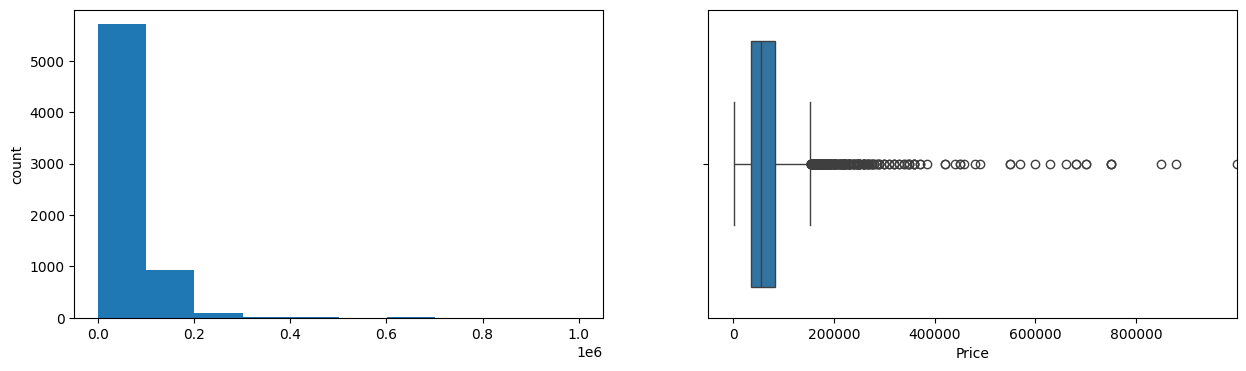

Year
Skew : -1.34


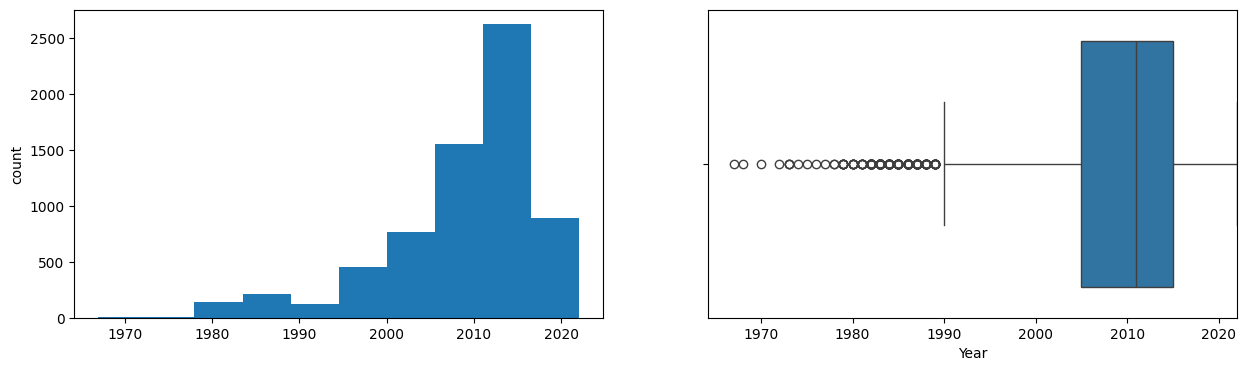

Engine_Capacity
Skew : 2.83


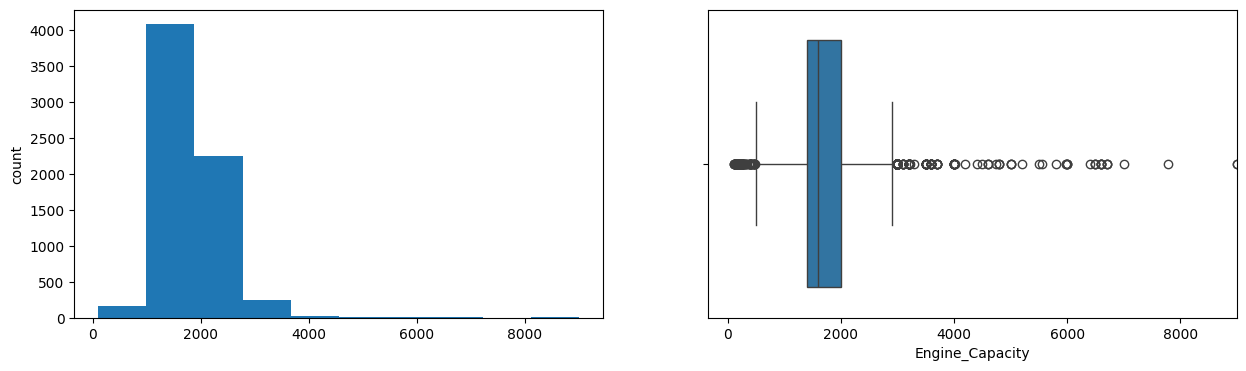

Kilometers_Driven
Skew : 82.35


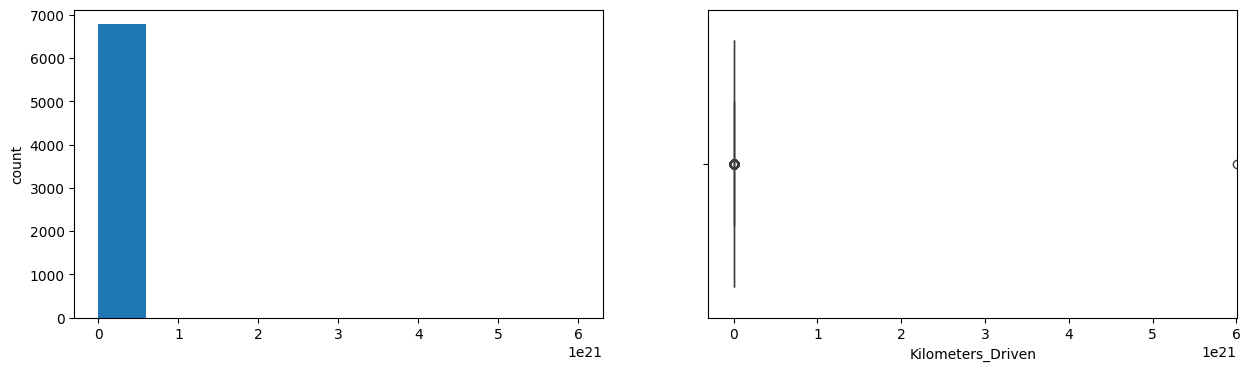

Seats
Skew : 41.72


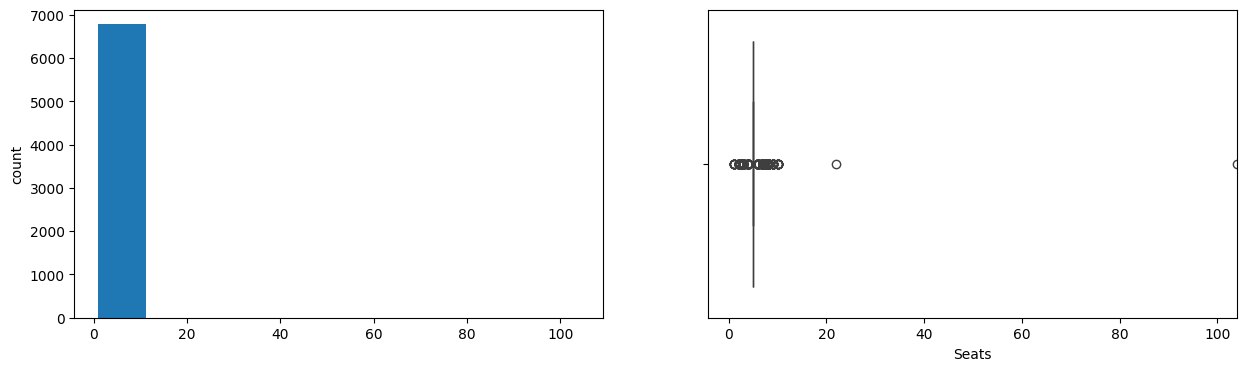

Previous_Owners
Skew : 82.35


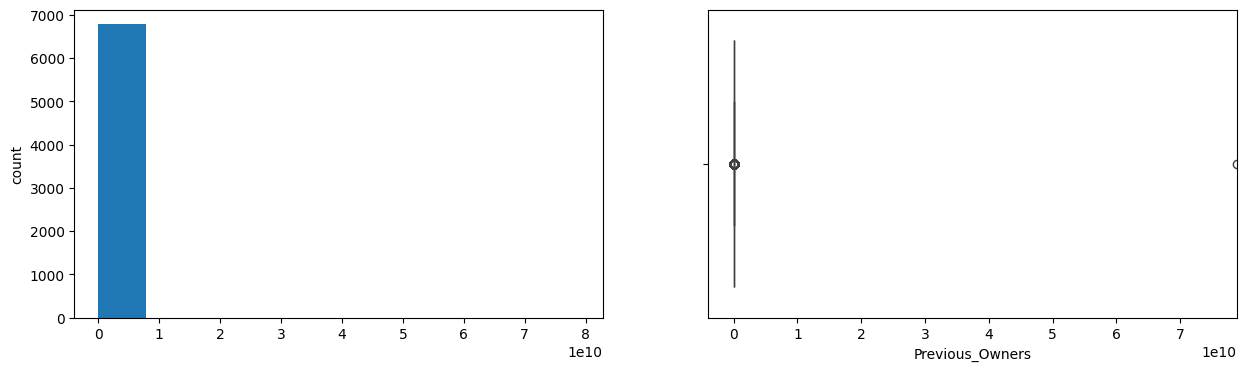

In [44]:
for col in numerical_cols:
    print(col)
    print('Skew :', round(stage3_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    stage3_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=stage3_df[col])
    plt.xlim(right=stage3_df[col].max())
    plt.show()

##### We can see from the above plots that the "Previous Owners", "Kilometers Driven" and "Seats" are skewed to the right so much we need to take care of the outliers they have

##### Now i wanna see the relationship between the "Year" and the "Kilometers_Driven" features, which should be a direct proportion between them, as we know the older the car the more distance it has traveled.
##### But first we wanna remove the outliers in the columns we mentioned above

#### Removing Outliers
starting with "Kilometers_Driven" i am excluding the values above 1M, because i think that these values are unrealistic especially that most of the cars in the data are new releases, seeing above a mean for the "Year" of 2008 is relativly new releases

In [45]:
threshold = 1000000
outliers = stage3_df[stage3_df["Kilometers_Driven"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

Now we want to remove the outliers of the "Previous_Owners", and excelude values over 10 because anywhere above that is kind of unrealistic("From My Experience").

In [46]:
threshold = 10
outliers = stage3_df[stage3_df["Previous_Owners"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

And to finish of with removing the outliers, the "Seats" feature would have at max 60 seats if it was a Large bus, so the threshold here is 60

In [47]:
threshold = 60
outliers = stage3_df[stage3_df["Seats"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

In [48]:
stage3_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,6590.0,NaN,NaN,NaN,67957.038392,57135.193323,1111.0,37000.0,55000.0,85000.0,999999.0
Brand,6590,40,فولكسفاجن,1106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,6590,391,اوكتافيا,499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,6590.0,NaN,NaN,NaN,2009.017602,8.33667,1967.0,2006.0,2011.0,2015.0,2022.0
Color,6590,26,أبيض,1356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel_Type,6590,4,بنزين,3841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_History,6590,6,خصوصي,5642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Licence,6590,2,فلسطينية,6519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission_Type,6590,3,اوتوماتيك,3548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Windows_Type,6590,2,الكتروني,6150,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Now the values are quite what we would expect, but that Engine Capacity of 9000cc is sus, there are trucks that can have that big of an engine i just wanna see if there's other things going on, so let's see the engine capacity values that are above than 5L

In [49]:
stage3_df.query("Engine_Capacity > 5000")

,Price,Brand,Model,Year,Color,Fuel_Type,Vehicle_History,Licence,Transmission_Type,Windows_Type,Engine_Capacity,Kilometers_Driven,Seats,Payment_Method,Listed_For,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Magnesium_Rims,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof
422,125000,داف,lf.55.220.,2009,أبيض,ديزل,تجاري,نمرة صفراء,عادي,الكتروني,5985,395606.0,3,نقدا فقط,للبيع فقط,1,1,1,1,1,1,1,0,0,0
543,150000,داف,55,2008,أبيض,ديزل,تجاري,فلسطينية,عادي,الكتروني,7000,423864.0,5,نقدا فقط,للبيع فقط,1,0,0,0,0,0,0,0,0,0
598,43000,جي,ام,2000,رمادي,ديزل,تجاري,فلسطينية,اوتوماتيك,الكتروني,6500,666666.0,9,إمكانية التقسيط,للبيع أو التبديل,2,1,1,1,0,0,1,0,0,0
1050,19000,دايو,ماتيز,2000,أخضر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,9000,20003.0,5,إمكانية التقسيط,للبيع أو التبديل,1,1,1,1,1,1,1,1,0,0
1337,115000,داف,55,2011,أبيض عاجي,ديزل,تجاري,فلسطينية,عادي,الكتروني,5983,350000.0,3,نقدا فقط,للبيع فقط,1,1,1,1,0,1,1,0,0,0
1882,17000,داف,45,1995,أبيض عاجي,ديزل,تدريب سياقة,فلسطينية,عادي,يدوي,5800,350000.0,2,نقدا فقط,للبيع أو التبديل,2,1,0,0,0,0,1,1,0,0
2230,30000,جي,ام,2002,أبيض,ديزل,حكومي,فلسطينية,اوتوماتيك,الكتروني,6500,200000.0,8,إمكانية التقسيط,للبيع أو التبديل,2,1,1,0,1,1,1,0,0,0
2363,65000,مرسيدس,416,2002,أبيض,ديزل,تجاري,فلسطينية,عادي,الكتروني,7777,593409.0,8,إمكانية التقسيط,للبيع فقط,2,1,1,1,0,1,1,1,0,0
2474,5500,فيات,سيات,1985,أحمر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,9000,948024.0,5,نقدا فقط,للبيع فقط,3,1,1,0,1,0,1,1,0,0
2571,27000,مرسيدس,914,1995,أبيض عاجي,ديزل,تجاري,فلسطينية,عادي,يدوي,5555,684186.0,3,إمكانية التقسيط,للبيع أو التبديل,5,1,0,0,0,0,0,0,0,0


As i expected the cars that have engine capacity listed as 9000cc are infact cars that their engine capacity is around 800cc which is a big gap, so i think the best thing to do here is to remove the rows that have their Engine Capacity values over 7000cc, so let's do it.

In [50]:
threshold = 7000
outliers = stage3_df[stage3_df["Engine_Capacity"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

#### Now let's go back to see the relationship between the "Year" and "Kilometers_Driven"

Text(0.5, 1.0, 'Year Released vs Kilometers Driven')

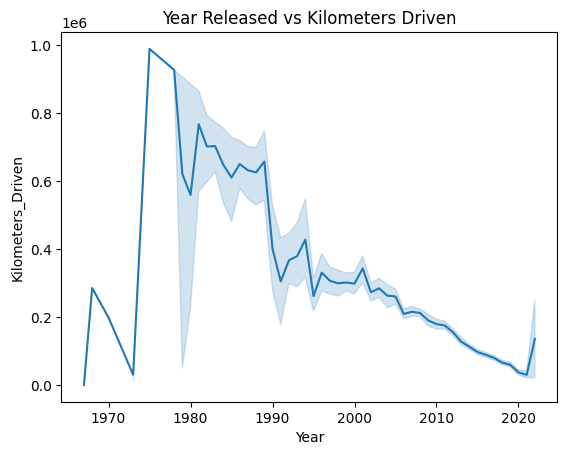

In [51]:
ax = sns.lineplot(x="Year",y="Kilometers_Driven",data=stage3_df)
ax.set_title("Year Released vs Kilometers Driven")                              

##### The above chart is almost what we would expect except for the year before 1975 or something, becuase as we can see the value for kilometers driven at that point had a massive jump, which is not what we would expect, so i want to see the cars that are older than 1980 and check them.

In [52]:
stage3_df.query("Year < 1980")

,Price,Brand,Model,Year,Color,Fuel_Type,Vehicle_History,Licence,Transmission_Type,Windows_Type,Engine_Capacity,Kilometers_Driven,Seats,Payment_Method,Listed_For,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Magnesium_Rims,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof
18,1800,اوبل,اسكونا,1967,أزرق,بنزين,خصوصي,فلسطينية,عادي,يدوي,1200,1000.0,5,إمكانية التقسيط,للبيع فقط,2,1,0,0,1,0,0,0,0,0
168,15000,مرسيدس,200,1978,ذهبي,بنزين,عمومي,فلسطينية,اوتوماتيك,يدوي,2000,927288.0,5,إمكانية التقسيط,للبيع أو التبديل,4,1,0,0,1,0,0,0,0,0
321,13000,فيات,127,1975,أخضر,بنزين,خصوصي,فلسطينية,عادي,الكتروني,900,989107.0,5,نقدا فقط,للبيع أو التبديل,5,1,0,0,1,0,1,1,0,0
662,18000,بيجو,404,1970,أزرق سماوي,بنزين,خصوصي,فلسطينية,عادي,يدوي,1600,199000.0,8,نقدا فقط,للبيع فقط,2,0,0,0,0,0,0,1,0,0
1498,27000,فيات,فيات,1973,أحمر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1800,50000.0,5,نقدا فقط,للبيع فقط,5,1,0,0,0,0,0,1,0,0
1516,3000,فيات,127,1979,أبيض,بنزين,خصوصي,فلسطينية,عادي,يدوي,900,906681.0,5,نقدا فقط,للبيع فقط,5,0,0,0,0,0,0,0,0,0
2875,3500,فيات,127,1979,أصفر,بنزين,خصوصي,فلسطينية,عادي,يدوي,900,906681.0,5,نقدا فقط,للبيع فقط,4,1,0,0,0,0,0,1,0,0
3472,6000,رينو,12ستيشن,1977,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,1300,947894.0,5,نقدا فقط,للبيع أو التبديل,3,0,0,0,0,0,0,0,0,0
3570,25000,فولكسفاجن,كبينة,1973,أصفر,بنزين,خصوصي,فلسطينية,عادي,يدوي,1600,12000.0,7,نقدا فقط,للبيع فقط,5,0,0,0,0,0,0,0,0,0
3619,18000,بي,ام,1978,ذهبي,بنزين,خصوصي,فلسطينية,عادي,يدوي,2000,927288.0,5,نقدا فقط,للبيع فقط,4,0,0,1,1,0,0,1,1,0


Now looking at the table above, the cars are very old almost as old as my father and in comparison to the dataset these can be considered outliers so i think the best thing to is to remove them

In [53]:
threshold = 1981
outliers = stage3_df[stage3_df["Year"] < threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

Now let's look at the chart again

Text(0.5, 1.0, 'Year Released vs Kilometers Driven')

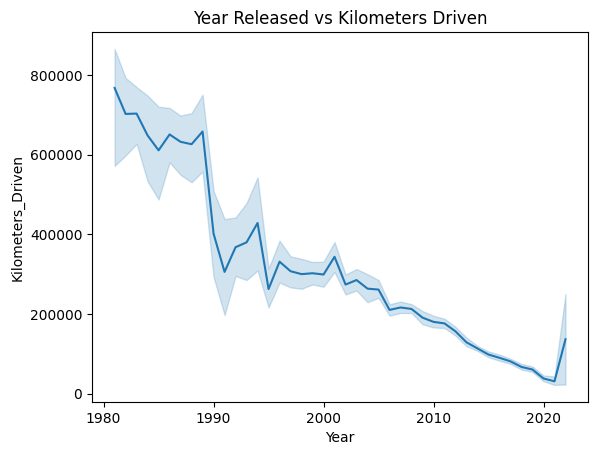

In [54]:
ax = sns.lineplot(x="Year",y="Kilometers_Driven",data=stage3_df)
ax.set_title("Year Released vs Kilometers Driven")    

The other thing i noticed is the suddent increase at the 2020 mark, it's not natural like that which is very sus, so let's check them out

In [55]:
stage3_df.query("Year > 2020")

,Price,Brand,Model,Year,Color,Fuel_Type,Vehicle_History,Licence,Transmission_Type,Windows_Type,Engine_Capacity,Kilometers_Driven,Seats,Payment_Method,Listed_For,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Magnesium_Rims,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof
5322,118000,هونداي,اكسنت,2021,أسود,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,20606.0,5,إمكانية التقسيط,للبيع فقط,0,1,1,1,0,1,0,0,0,0
5518,220000,كيا,سورينتو,2021,أبيض,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200,45279.0,6,إمكانية التقسيط,للبيع أو التبديل,0,0,1,1,1,1,0,1,1,1
5829,152000,فولكسفاجن,جولف,2021,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1500,7000.0,5,نقدا فقط,للبيع فقط,0,1,1,1,1,1,1,1,1,0
5852,110000,ستروين,بيرلينجو,2021,فيراني,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1500,40000.0,5,إمكانية التقسيط,للبيع فقط,0,0,0,0,0,0,0,0,0,0
5862,195000,الفا,روميو,2021,أسود,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,6800.0,5,نقدا فقط,للبيع فقط,0,1,1,1,1,1,1,1,1,0
5870,119000,سيت,ارونا,2021,فيراني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000,140000.0,5,نقدا فقط,للبيع فقط,0,1,1,1,1,1,1,1,0,0
5880,115000,سيت,ارونا,2021,أحمر,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000,20000.0,5,إمكانية التقسيط,للتبديل فقط,0,1,1,1,1,1,1,1,0,0
5931,195000,سكودا,citigo,2021,أسود ميتالك,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,44000.0,5,نقدا فقط,للبيع أو التبديل,0,1,1,1,1,1,1,1,0,0
5940,11000,دراجة,نارية,2021,أحمر,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,125,3000.0,2,نقدا فقط,للبيع فقط,0,0,0,0,0,0,0,0,0,0
5963,90000,كيا,ريو,2021,أخضر,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1400,13600.0,5,نقدا فقط,للبيع فقط,0,1,1,1,1,1,1,1,1,0


So there are a few that are outliers so i am thinking of removing the ones that have their kilometers driven above 50k, let's see how that goes

In [56]:
outliers = stage3_df[(stage3_df["Year"] > 2020) & (stage3_df["Kilometers_Driven"] > 50000)]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

Text(0.5, 1.0, 'Year Released vs Kilometers Driven')

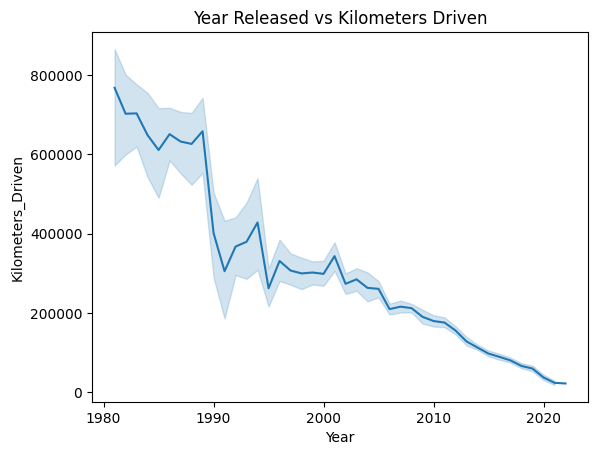

In [57]:
ax = sns.lineplot(x="Year",y="Kilometers_Driven",data=stage3_df)
ax.set_title("Year Released vs Kilometers Driven")    

Now it looks good, let's go to the next thing

#### The other thing i want is to see is the unique values of each feature that has 2 possible values

In [58]:
columns = list(stage3_df.columns)
for col in columns:
    unique_list = stage3_df[col].unique()
    if len(unique_list) == 2:
        print(f'{col} Values: {unique_list}')

Licence Values: ['فلسطينية ' 'نمرة صفراء ']
Windows_Type Values: ['الكتروني ' 'يدوي ']
Payment_Method Values: ['نقدا فقط ' 'إمكانية التقسيط ']
Radio Values: [1 0]
Air_Conditioner Values: [1 0]
Central_Lock Values: [1 0]
Magnesium_Rims Values: [1 0]
Airbag Values: [1 0]
Alert_System Values: [1 0]
Leather_Seats Values: [1 0]
Sunroof Values: [1 0]
Panoramic Sunroof Values: [1 0]


##### From the above breakdown of the features, we can see a few that has two categories which we can replace to zeros and ones (Binary)

The ones we want to binarize are "Licence", "Windows_Type", "Payment_Method"
##### Binarization

##### So lets Binarize the above features, 

for the "Licence" {1 for فلسطينية} {0 for نمرة صفراء}

for the "Windows_Type" {1 for الكتروني}{0 for يدوي}

for the "Payment_Method" {1 for نقدا فقط'}{0 for 'إمكانية التقسيط'}


In [59]:
stage3_df["Licence"] = stage3_df["Licence"].str.strip()
stage3_df["Licence"] = stage3_df["Licence"].map({
    "فلسطينية": 1,
    "نمرة صفراء": 0
})

stage3_df["Windows_Type"] = stage3_df["Windows_Type"].str.strip()
stage3_df["Windows_Type"] = stage3_df["Windows_Type"].map({
    "الكتروني": 1,
    "يدوي": 0
})

stage3_df["Payment_Method"] = stage3_df["Payment_Method"].str.strip()
stage3_df["Payment_Method"] = stage3_df["Payment_Method"].map({
    "نقدا فقط": 0,
    "إمكانية التقسيط": 1
})

In [60]:
stage3_df = stage3_df.rename(columns={
    "Licence":"Palestinian_Licence",
    "Windows_Type":"Electric_Windows",
    "Payment_Method":"Installment_Payment_Method"
    })

stage3_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,6566.0,NaN,NaN,NaN,68079.208498,57116.794042,1111.0,37000.0,55000.0,85000.0,999999.0
Brand,6566,40,فولكسفاجن,1102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,6566,385,اوكتافيا,499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,6566.0,NaN,NaN,NaN,2009.107981,8.15916,1981.0,2006.0,2011.0,2015.0,2022.0
Color,6566,26,أبيض,1352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel_Type,6566,4,بنزين,3818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_History,6566,6,خصوصي,5620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Palestinian_Licence,6566.0,NaN,NaN,NaN,0.989187,0.103431,0.0,1.0,1.0,1.0,1.0
Transmission_Type,6566,3,اوتوماتيك,3544,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Electric_Windows,6566.0,NaN,NaN,NaN,0.935425,0.245793,0.0,1.0,1.0,1.0,1.0


#### Now if we recall the charts at the begining where we showed the skew, we can see the numerical features looking better with less skew, but there is still

##### 

Price
Skew : 5.09


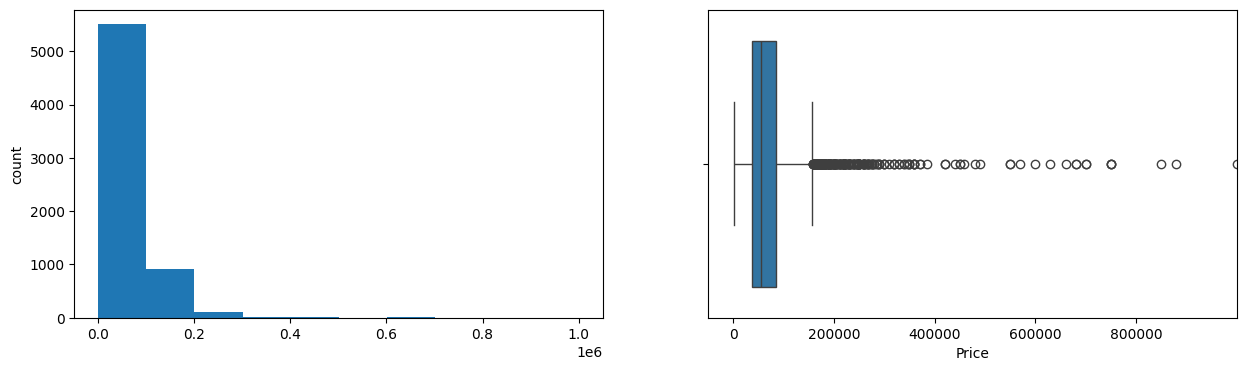

Year
Skew : -1.31


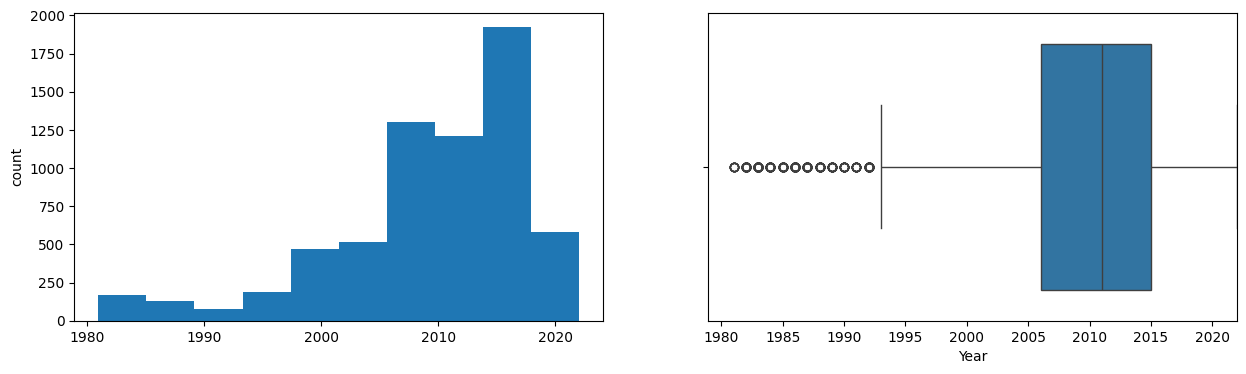

Engine_Capacity
Skew : 2.36


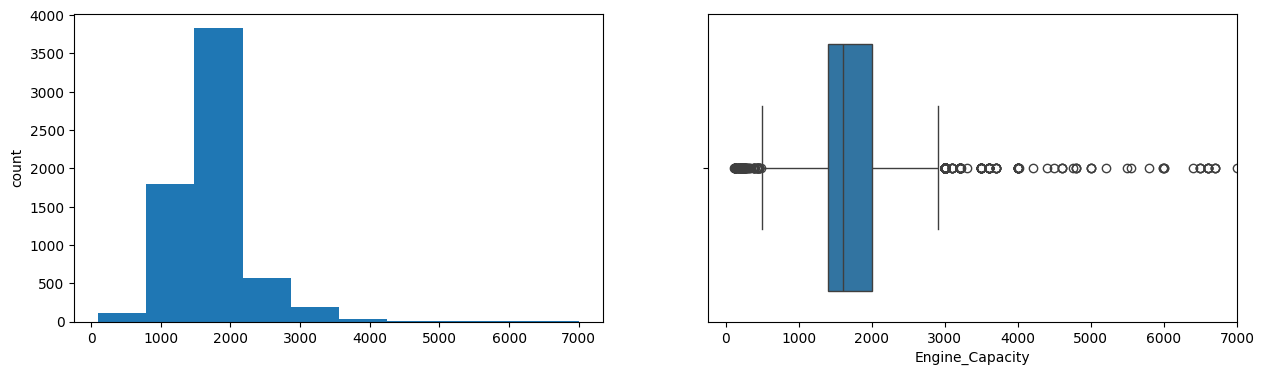

Kilometers_Driven
Skew : 1.95


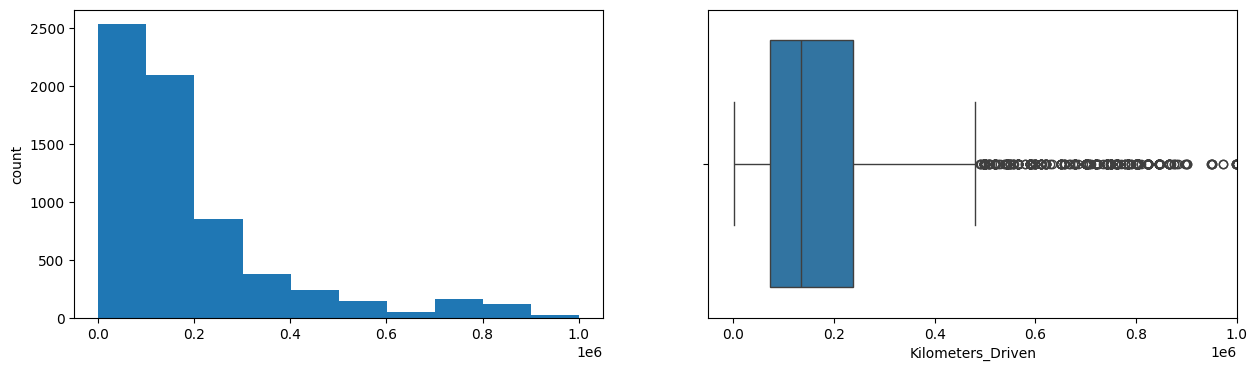

Seats
Skew : 2.03


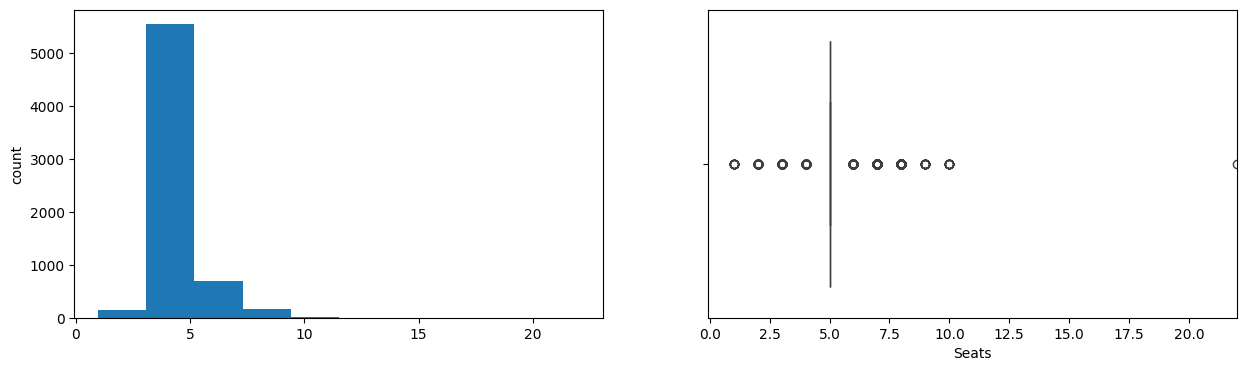

Previous_Owners
Skew : 1.7


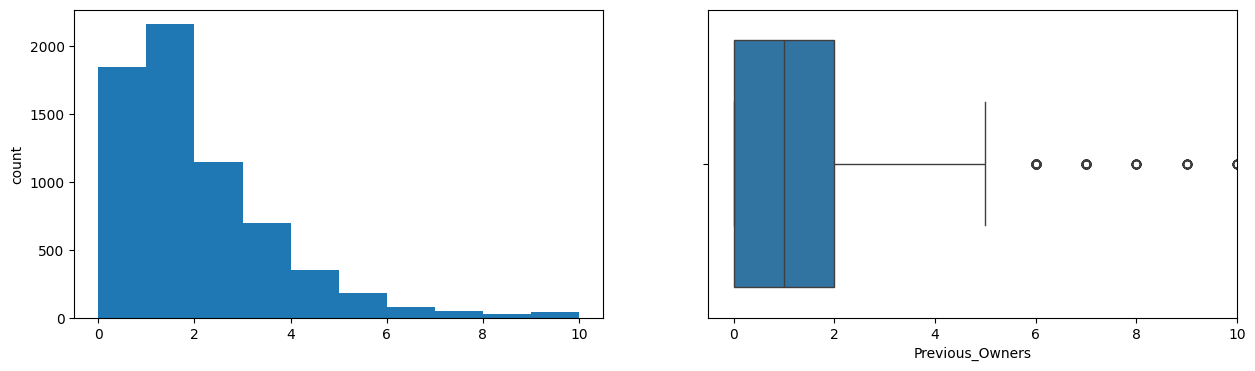

In [61]:
for col in numerical_cols:
    print(col)
    print('Skew :', round(stage3_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    stage3_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=stage3_df[col])
    plt.xlim(right=stage3_df[col].max())
    plt.show()

#### From the charts above, what catches my eyes are the Kilometers_Driven and the Previous_Owners features, and i'll go over them below, the rest are as i would expect them to be

#### Kilometers_Driven
##### I want to damp down the values here and normalize them which would help to reduce the gap between its values and the other features (we'll see how that helps when we reach the "converting ctagories to numeric" step) and would also help with the skew a bit, so what i've chose is the ZScore method, so let's impliment it
##### The mean and the std should be exported to be used in the transformation of future data to predict

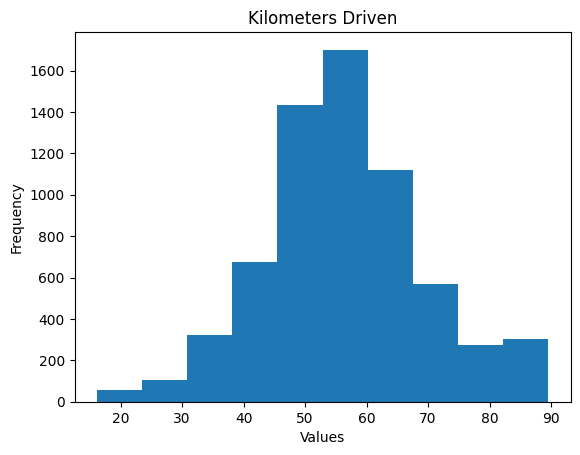

0.21896421711789488

In [62]:
l, optimal_lambda = stats.boxcox(np.array(stage3_df['Kilometers_Driven']))
stage3_df['Kilometers_Driven_boxcox'] = stats.boxcox(stage3_df['Kilometers_Driven'], lmbda=optimal_lambda)

# stage3_df['Kilometers_Driven_ZScore'] = stats.zscore(stage3_df['Kilometers_Driven'])

# mean_kilometers_driven = stage3_df['Kilometers_Driven_ZScore'].mean()
# std_kilometers_driven = stage3_df['Kilometers_Driven_ZScore'].std()


stage3_df['Kilometers_Driven_boxcox'].plot(kind="hist",title="Kilometers Driven",xlabel="Values")

plt.show()
optimal_lambda

##### The above graph seems way better now, let's continue

#### Previous_Owners
##### I was thinking of doing some adaptive binning to this feature, but as of my experience in this field i have some ranges that people create in their minds about cars and these ranges are what i belive affect the price not the numerical ranges, so (As of my experience) i would make fixed ranges for the feature as follows (0-2),(3-4)(5 and above), so let's get to it

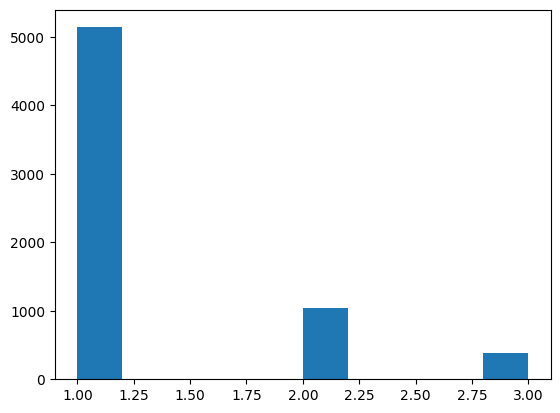

,Price,Brand,Model,Year,Color,Fuel_Type,Vehicle_History,Palestinian_Licence,Transmission_Type,Electric_Windows,Engine_Capacity,Kilometers_Driven,Seats,Installment_Payment_Method,Listed_For,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Magnesium_Rims,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof,Kilometers_Driven_boxcox,Previous_Owners_Ranges,Previous_Owners_Labels
0,100000,كيا,اوبتيما,2014,أبيض عاجي,بنزين,خصوصي,1,اوتوماتيك,1,2000,75000.0,5,0,للبيع فقط,0,1,1,1,1,1,1,1,1,1,48.777688,[0-2],1
1,60000,كيا,سورينتو,2007,سكني,ديزل,خصوصي,1,نصف اوتوماتيك,1,2500,130000.0,8,1,للبيع أو التبديل,2,1,1,1,1,1,1,1,1,0,55.605460,[0-2],1
2,43500,هونداي,افانتي,2006,سكني,بنزين,خصوصي,1,اوتوماتيك,1,1600,175154.0,5,0,للبيع فقط,1,1,1,1,1,1,1,1,0,0,59.664567,[0-2],1
3,5500,فيات,127,1982,بيج,بنزين,خصوصي,1,عادي,0,906,844862.0,5,1,للبيع فقط,4,1,1,0,0,0,0,0,0,0,86.085768,[3-4],2
4,54000,بيجو,208,2014,فضي,بنزين,خصوصي,1,اوتوماتيك,1,1200,38000.0,5,0,للبيع فقط,0,0,1,1,1,1,1,0,0,0,41.398924,[0-2],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6561,50000,كيا,سول,2012,أبيض,ديزل,خصوصي,1,اوتوماتيك,1,1600,249037.0,5,0,للبيع فقط,1,1,1,1,0,1,0,0,0,0,64.810049,[0-2],1
6562,45000,كيا,مورننغ,2015,فيراني,كهرباء,خصوصي,1,اوتوماتيك,1,1000,130000.0,5,1,للبيع فقط,2,0,1,1,1,1,1,0,0,0,55.605460,[0-2],1
6563,48000,فورد,ترانزيت,2002,أبيض,ديزل,عمومي,1,عادي,1,2400,475435.0,8,0,للبيع فقط,5,1,0,0,0,0,0,0,0,0,75.362465,[5+),3
6564,87000,بيجو,بارتنر,2018,فضي,ديزل,خصوصي,1,عادي,1,1600,50000.0,5,0,للبيع فقط,0,1,1,1,0,1,1,0,0,0,44.245778,[0-2],1


In [63]:
stage3_df['Previous_Owners_Ranges'] = pd.cut(stage3_df['Previous_Owners'], bins=[-1, 2, 4, 100], labels=['[0-2]', '[3-4]', '[5+)'])
stage3_df['Previous_Owners_Labels'] = pd.cut(stage3_df['Previous_Owners'], bins=[-1, 2, 4, 100], labels=[1, 2, 3])

stage3_df["Previous_Owners_Labels"].hist(grid=False)
plt.show()

stage3_df

##### I also want to bin the Seats value, and i would use fixed bins as follows: 1 for bikes, 2 for coupes or muscle cars or supercars, 3 - 5 for sedans, 6 - 7 for SUVs, above for buses

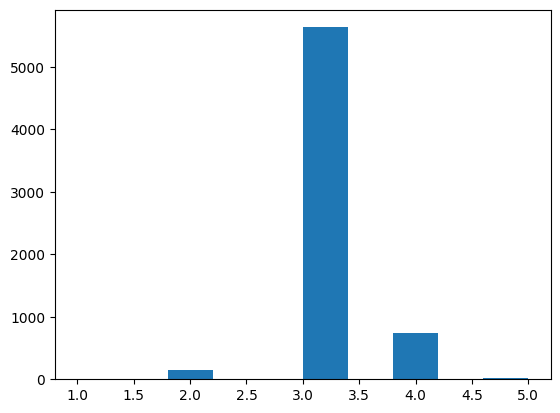

['[3-5]', '[6-7]', '[2]', '[1]', '[8+)']
Categories (5, object): ['[1]' < '[2]' < '[3-5]' < '[6-7]' < '[8+)']

In [64]:
stage3_df['Seats_Ranges'] = pd.cut(stage3_df['Seats'], bins=[-1, 1, 3,6,8,100], labels=['[1]', '[2]', '[3-5]', '[6-7]', '[8+)'])
stage3_df['Seats_Labels'] = pd.cut(stage3_df['Seats'], bins=[-1, 1, 3,6,8,100], labels=[1, 2, 3, 4, 5])

stage3_df["Seats_Labels"].hist(grid=False)
plt.show()
stage3_df["Seats_Ranges"].unique()

##### And i also noticed the Engine capacity has a few values over ~4000cc so i am thinking of removing as i consider them outliers

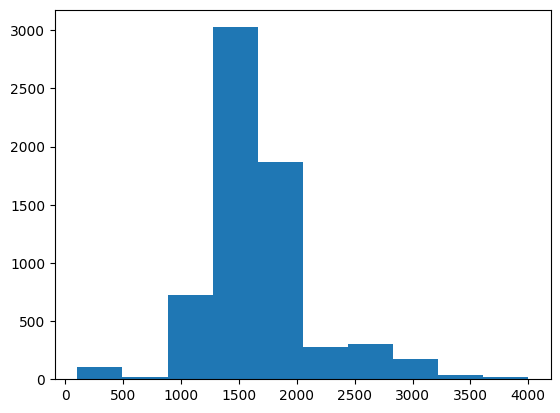

In [65]:
threshold = 4000
outliers = stage3_df[stage3_df["Engine_Capacity"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

stage3_df["Engine_Capacity"].hist(grid=False)
plt.show()

#### And the last thing i wanna do, is removing the outliers that have their price up in the sky, from the chart above it seems like removing the ones that have their price above ~200000 is a good choice

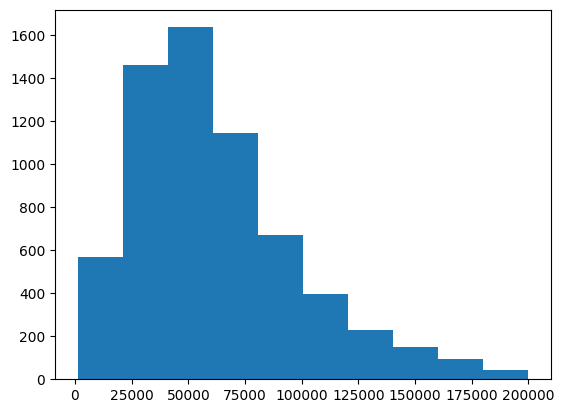

In [66]:
threshold = 200000
outliers = stage3_df[stage3_df["Price"] > threshold]

stage3_df = stage3_df.drop(outliers.index).reset_index(drop=True)

stage3_df["Price"].hist(grid=False)
plt.show()

It looks good now, so let's see how much we've cleaned of our data

In [67]:
stage3_df.shape

(6389, 30)

so now we're down to about 6300 rows which is very good considering we've cut down alot of outliers and made the data look a lot better

#### Now we have a few catagorical features that need to be transformed to numerical types, one of the ways we can do that is dealing with each unique value as a stand alone feature, the only thing that i am hesitant about is wheather i merge the Brand and the Model features into one or keep them as they are currenlty, we can't judge until we compare the two approaches, so lets start 

###### Brand

In [68]:
brand_le = LabelEncoder()
brand_labels = brand_le.fit_transform(stage3_df['Brand'])

brand_onehot = OneHotEncoder()
brand_feature_arr = brand_onehot.fit_transform(
                              stage3_df[['Brand']]).toarray()

brand_onehot_feature_labels = list(brand_le.classes_)

brand_onehot_features = pd.DataFrame(brand_feature_arr, 
                            columns=brand_onehot_feature_labels)

stage3_df = pd.concat([stage3_df[stage3_df.columns],brand_onehot_features],axis=1)

###### Model

In [69]:
model_le = LabelEncoder()
model_labels = model_le.fit_transform(stage3_df['Model'])

model_onehot = OneHotEncoder()
model_feature_arr = model_onehot.fit_transform(
                              stage3_df[['Model']]).toarray()

model_onehot_feature_labels = ['Model_'+str(label)
                           for label in model_le.classes_]

model_onehot_features = pd.DataFrame(model_feature_arr, 
                            columns=model_onehot_feature_labels)
stage3_df = pd.concat([stage3_df[stage3_df.columns],model_onehot_features],axis=1)

In [70]:
# stage3_df["Brand_Model"] = stage3_df["Brand"] + "_" + stage3_df["Model"]

In [71]:
# brand_model_le = LabelEncoder()
# brand_model_labels = brand_model_le.fit_transform(stage3_df['Brand_Model'])

# brand_model_onehot = OneHotEncoder()
# brand_model_feature_arr = brand_model_onehot.fit_transform(
#                               stage3_df[['Brand_Model']]).toarray()

# brand_model_onehot_feature_labels = list(brand_model_le.classes_)

# brand_model_onehot_features = pd.DataFrame(brand_model_feature_arr, 
#                             columns=brand_model_onehot_feature_labels)

# stage3_df = pd.concat([stage3_df[stage3_df.columns],brand_model_onehot_features],axis=1)

##### Now i want to remove some features that i think are irrelevant to car price. the Color, and Magnesium_Rims, Listed_For, these three don't provide much of a value so i am removing them

In [72]:
stage3_df = stage3_df.drop(columns=["Color","Magnesium_Rims","Listed_For"]).reset_index(drop=True)

##### Now Let's continue

###### Fuel_Type

In [73]:
fuel_type_le = LabelEncoder()
fuel_type_labels = fuel_type_le.fit_transform(stage3_df['Fuel_Type'])

fuel_type_onehot = OneHotEncoder()
fuel_type_feature_arr = fuel_type_onehot.fit_transform(
                              stage3_df[['Fuel_Type']]).toarray()

fuel_type_onehot_feature_labels = list(fuel_type_le.classes_)

fuel_type_onehot_features = pd.DataFrame(fuel_type_feature_arr, 
                            columns=fuel_type_onehot_feature_labels)

##### Now regarding the fuel type, its know for the cars that are hyprid or electric to be a bit more pricey than other cars, so to accommodate for this, i would think that after we did the onehotencoding giving a bit more weight to the hyprid and electric variants would make sense, so let's do it

In [74]:
fuel_type_onehot_features["كهرباء "] = fuel_type_onehot_features["كهرباء "]*2.5
fuel_type_onehot_features["هايبرد "] = fuel_type_onehot_features["هايبرد "]*1.5

stage3_df = pd.concat([stage3_df[stage3_df.columns],fuel_type_onehot_features],axis=1)
fuel_type_onehot_features

,بنزين,ديزل,كهرباء,هايبرد
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
6384,0.0,1.0,0.0,0.0
6385,0.0,0.0,2.5,0.0
6386,0.0,1.0,0.0,0.0
6387,0.0,1.0,0.0,0.0


###### Vehicle_History

In [75]:
vehicle_history_le = LabelEncoder()
vehicle_history_labels = vehicle_history_le.fit_transform(stage3_df['Vehicle_History'])

vehicle_history_onehot = OneHotEncoder()
vehicle_history_feature_arr = vehicle_history_onehot.fit_transform(
                              stage3_df[['Vehicle_History']]).toarray()

vehicle_history_onehot_feature_labels = list(vehicle_history_le.classes_)

vehicle_history_onehot_features = pd.DataFrame(vehicle_history_feature_arr, 
                            columns=vehicle_history_onehot_feature_labels)

stage3_df = pd.concat([stage3_df[stage3_df.columns],vehicle_history_onehot_features],axis=1)

###### Transmission_Type

In [76]:
transmission_type_le = LabelEncoder()
transmission_type_labels = transmission_type_le.fit_transform(stage3_df['Transmission_Type'])

transmission_type_onehot = OneHotEncoder()
transmission_type_feature_arr = transmission_type_onehot.fit_transform(
                              stage3_df[['Transmission_Type']]).toarray()

transmission_type_onehot_feature_labels = list(transmission_type_le.classes_)

transmission_type_onehot_features = pd.DataFrame(transmission_type_feature_arr, 
                            columns=transmission_type_onehot_feature_labels)

stage3_df = pd.concat([stage3_df[stage3_df.columns],transmission_type_onehot_features],axis=1)

In [77]:
stage3_df

,Price,Brand,Model,Year,Fuel_Type,Vehicle_History,Palestinian_Licence,Transmission_Type,Electric_Windows,Engine_Capacity,Kilometers_Driven,Seats,Installment_Payment_Method,Previous_Owners,Radio,Air_Conditioner,Central_Lock,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof,Kilometers_Driven_boxcox,Previous_Owners_Ranges,Previous_Owners_Labels,Seats_Ranges,Seats_Labels,Dodge,أفيكو,الفا,اوبل,اودي,ايسوزو,باص,بي,بيجو,تويوتا,جاجوار,جي,جييب,داتشيا,داف,دايو,دراجة,ديهاتسو,روفر,رينو,سانغ,ستروين,سكودا,سوبارو,سوزوكي,سيت,شاحنة,شفروليه,فورد,فولفو,فولكسفاجن,فيات,كيا,لاندروفر,مازدا,مرسيدس,ميتسوبيشي,نيسان,هوندا,هونداي,Model_,Model_107,Model_1117,Model_127,Model_150E25,Model_1524,Model_1624,Model_170,Model_180,Model_190,Model_200,Model_2008,Model_205,Model_206,Model_206+,Model_207,Model_208,Model_212,Model_220,Model_230,Model_240,Model_250,Model_260,Model_280,Model_3,Model_300,Model_3008,Model_301,Model_305,Model_306,Model_307,Model_308,Model_313,Model_323,Model_350,Model_405,Model_406,Model_407,Model_410,Model_411,Model_412,Model_413,Model_416,Model_45,Model_5,Model_5008,Model_508,Model_50C13,Model_518,Model_519,Model_55,Model_6,Model_607,Model_614,Model_65C18,Model_711,Model_80,Model_814,Model_87,Model_88,Model_914,Model_A3,Model_A4,Model_A6,Model_A8,Model_A80,Model_B2500,Model_B3,Model_B4,Model_BT50,Model_C,Model_C-Elysee,Model_C1,Model_C180,Model_C200,Model_C220,Model_C230,Model_C250,Model_C270,Model_C3,Model_C5,Model_CC,Model_CF85,Model_CLA180,Model_CR-V,Model_Compas,Model_Compass,Model_DS3,Model_Ds5,Model_E200,Model_E220,Model_E230,Model_E250,Model_E270,Model_E280,Model_E300,Model_E320,Model_E350,Model_FH,Model_FL,Model_FL6,Model_FM,Model_Fl6,Model_GLA,Model_GLA200,Model_GTI,Model_Golf,Model_H1,Model_H100,Model_I30,Model_I300,Model_IVIECO,Model_K3,Model_K5,Model_Kawasaki,Model_L200,Model_L400,Model_LT,Model_LV200,Model_MPI,Model_Massey,Model_Patriot,Model_Q5,Model_Q7,Model_R5,Model_R9,Model_Renegade,Model_S320,Model_S500,Model_SL350,Model_Slin,Model_Spacetourer,Model_TT,Model_Tepee,Model_Tsi,Model_Vandora,Model_Wrangler,Model_XE,Model_c,Model_c15,Model_c3,Model_citigo,Model_cx3,Model_e270,Model_i10,Model_i20,Model_i25,Model_i30,Model_i40,Model_ix35,Model_k3,Model_s400,Model_t-cross,Model_t-roc,Model_tucan,Model_w210,Model_أتيكا,Model_أفيكو,Model_أفيوو,Model_ألتيما,Model_أماروك,Model_أوميغا,Model_إنسيجنيا,Model_ابيزا,Model_اتراج,Model_اتكو,Model_اتكوا,Model_اتوس,Model_اتيكو,Model_ارونا,Model_استر,Model_استرا,Model_اسكانيا,Model_اسكورت,Model_اسكونا,Model_افانتي,Model_افيو,Model_اكس,Model_اكسبرت,Model_اكسبرس,Model_اكسنت,Model_اكورد,Model_الانترا,Model_الميرا,Model_ام,Model_امبريزا,Model_اوبترا,Model_اوبتيما,Model_اوت,Model_اوتوبيانكي,Model_اورايون,Model_اوكتافيا,Model_اونو,Model_ايدج,Model_ايونيك,Model_باتريوت,Model_باجيرو,Model_بارتنر,Model_باسات,Model_باص,Model_باندا,Model_برايد,Model_برلنجو,Model_بورا,Model_بوكسر,Model_بولو,Model_بونتباك,Model_بونتو,Model_بونتياك,Model_بيرلينجو,Model_بيكاسو,Model_بيكانتو,Model_تراجيت,Model_ترافرس,Model_ترانزيت,Model_ترانسبورتر,Model_تروبر,Model_تعديل,Model_تندر,Model_توران,Model_توسان,Model_توكسون,Model_توليدو,Model_تيبو,Model_تيجوان,Model_تيدا,Model_تيراكان,Model_تيرانو,Model_تيمبرا,Model_تيندرا,Model_جالانت,Model_جامبي,Model_جوالف,Model_جوك,Model_جولف,Model_جيتا,Model_جيتس,Model_داستر,Model_داف,Model_دوبلو,Model_دوكر,Model_ديسكفري,Model_ديفندر,Model_ديلي,Model_ديماكس,Model_رابيد,Model_راف,Model_رايسر,Model_رومستر,Model_روميو,Model_ريجاتا,Model_رينج,Model_رينو,Model_ريو,Model_زافيرا,Model_سانتافيه,Model_سبارك,Model_سبرنتر,Model_سبورتاج,Model_سبيرو,Model_سبيس,Model_ستونك,Model_ستيب,Model_ستيشن,Model_سكالا,Model_سكانيا,Model_سلندر,Model_سنتافاي,Model_سنتافيه,Model_سنتانا,Model_سوبر,Model_سوبيرب,Model_سورينتو,Model_سول,Model_سوناتا,Model_سويفت,Model_سيراتو,Model_سيفيك,Model_سييد,Model_شبح,Model_شيروكو,Model_شيروكي,Model_طوارق,Model_عريض,Model_غواصة,Model_فابيا,Model_فرينو,Model_فلوانس,Model_فورتي,Model_فوكس,Model_فولفو,Model_فولكس,Model_فيانو,Model_فيتو,Model_فيرنا,Model_فيستا,Model_فيكترا,Model_ف

#### Now i think we're ready to test the ML Algorithms and see what happens

##### First i wanna create a seperate DataFrame with only the columns that we're going to use

In [78]:
stage3_df.columns[:30]

Index(['Price', 'Brand', 'Model', 'Year', 'Fuel_Type', 'Vehicle_History',
       'Palestinian_Licence', 'Transmission_Type', 'Electric_Windows',
       'Engine_Capacity', 'Kilometers_Driven', 'Seats',
       'Installment_Payment_Method', 'Previous_Owners', 'Radio',
       'Air_Conditioner', 'Central_Lock', 'Airbag', 'Alert_System',
       'Leather_Seats', 'Sunroof', 'Panoramic Sunroof',
       'Kilometers_Driven_boxcox', 'Previous_Owners_Ranges',
       'Previous_Owners_Labels', 'Seats_Ranges', 'Seats_Labels', 'Dodge',
       'أفيكو', 'الفا'],
      dtype='object')

In [79]:
test_df = stage3_df.copy()
test_df = test_df.drop(columns=["Brand","Model","Fuel_Type","Transmission_Type","Vehicle_History","Previous_Owners_Ranges","Previous_Owners","Kilometers_Driven","Seats","Seats_Ranges"]).reset_index(drop=True)
test_df

,Price,Year,Palestinian_Licence,Electric_Windows,Engine_Capacity,Installment_Payment_Method,Radio,Air_Conditioner,Central_Lock,Airbag,Alert_System,Leather_Seats,Sunroof,Panoramic Sunroof,Kilometers_Driven_boxcox,Previous_Owners_Labels,Seats_Labels,Dodge,أفيكو,الفا,اوبل,اودي,ايسوزو,باص,بي,بيجو,تويوتا,جاجوار,جي,جييب,داتشيا,داف,دايو,دراجة,ديهاتسو,روفر,رينو,سانغ,ستروين,سكودا,سوبارو,سوزوكي,سيت,شاحنة,شفروليه,فورد,فولفو,فولكسفاجن,فيات,كيا,لاندروفر,مازدا,مرسيدس,ميتسوبيشي,نيسان,هوندا,هونداي,Model_,Model_107,Model_1117,Model_127,Model_150E25,Model_1524,Model_1624,Model_170,Model_180,Model_190,Model_200,Model_2008,Model_205,Model_206,Model_206+,Model_207,Model_208,Model_212,Model_220,Model_230,Model_240,Model_250,Model_260,Model_280,Model_3,Model_300,Model_3008,Model_301,Model_305,Model_306,Model_307,Model_308,Model_313,Model_323,Model_350,Model_405,Model_406,Model_407,Model_410,Model_411,Model_412,Model_413,Model_416,Model_45,Model_5,Model_5008,Model_508,Model_50C13,Model_518,Model_519,Model_55,Model_6,Model_607,Model_614,Model_65C18,Model_711,Model_80,Model_814,Model_87,Model_88,Model_914,Model_A3,Model_A4,Model_A6,Model_A8,Model_A80,Model_B2500,Model_B3,Model_B4,Model_BT50,Model_C,Model_C-Elysee,Model_C1,Model_C180,Model_C200,Model_C220,Model_C230,Model_C250,Model_C270,Model_C3,Model_C5,Model_CC,Model_CF85,Model_CLA180,Model_CR-V,Model_Compas,Model_Compass,Model_DS3,Model_Ds5,Model_E200,Model_E220,Model_E230,Model_E250,Model_E270,Model_E280,Model_E300,Model_E320,Model_E350,Model_FH,Model_FL,Model_FL6,Model_FM,Model_Fl6,Model_GLA,Model_GLA200,Model_GTI,Model_Golf,Model_H1,Model_H100,Model_I30,Model_I300,Model_IVIECO,Model_K3,Model_K5,Model_Kawasaki,Model_L200,Model_L400,Model_LT,Model_LV200,Model_MPI,Model_Massey,Model_Patriot,Model_Q5,Model_Q7,Model_R5,Model_R9,Model_Renegade,Model_S320,Model_S500,Model_SL350,Model_Slin,Model_Spacetourer,Model_TT,Model_Tepee,Model_Tsi,Model_Vandora,Model_Wrangler,Model_XE,Model_c,Model_c15,Model_c3,Model_citigo,Model_cx3,Model_e270,Model_i10,Model_i20,Model_i25,Model_i30,Model_i40,Model_ix35,Model_k3,Model_s400,Model_t-cross,Model_t-roc,Model_tucan,Model_w210,Model_أتيكا,Model_أفيكو,Model_أفيوو,Model_ألتيما,Model_أماروك,Model_أوميغا,Model_إنسيجنيا,Model_ابيزا,Model_اتراج,Model_اتكو,Model_اتكوا,Model_اتوس,Model_اتيكو,Model_ارونا,Model_استر,Model_استرا,Model_اسكانيا,Model_اسكورت,Model_اسكونا,Model_افانتي,Model_افيو,Model_اكس,Model_اكسبرت,Model_اكسبرس,Model_اكسنت,Model_اكورد,Model_الانترا,Model_الميرا,Model_ام,Model_امبريزا,Model_اوبترا,Model_اوبتيما,Model_اوت,Model_اوتوبيانكي,Model_اورايون,Model_اوكتافيا,Model_اونو,Model_ايدج,Model_ايونيك,Model_باتريوت,Model_باجيرو,Model_بارتنر,Model_باسات,Model_باص,Model_باندا,Model_برايد,Model_برلنجو,Model_بورا,Model_بوكسر,Model_بولو,Model_بونتباك,Model_بونتو,Model_بونتياك,Model_بيرلينجو,Model_بيكاسو,Model_بيكانتو,Model_تراجيت,Model_ترافرس,Model_ترانزيت,Model_ترانسبورتر,Model_تروبر,Model_تعديل,Model_تندر,Model_توران,Model_توسان,Model_توكسون,Model_توليدو,Model_تيبو,Model_تيجوان,Model_تيدا,Model_تيراكان,Model_تيرانو,Model_تيمبرا,Model_تيندرا,Model_جالانت,Model_جامبي,Model_جوالف,Model_جوك,Model_جولف,Model_جيتا,Model_جيتس,Model_داستر,Model_داف,Model_دوبلو,Model_دوكر,Model_ديسكفري,Model_ديفندر,Model_ديلي,Model_ديماكس,Model_رابيد,Model_راف,Model_رايسر,Model_رومستر,Model_روميو,Model_ريجاتا,Model_رينج,Model_رينو,Model_ريو,Model_زافيرا,Model_سانتافيه,Model_سبارك,Model_سبرنتر,Model_سبورتاج,Model_سبيرو,Model_سبيس,Model_ستونك,Model_ستيب,Model_ستيشن,Model_سكالا,Model_سكانيا,Model_سلندر,Model_سنتافاي,Model_سنتافيه,Model_سنتانا,Model_سوبر,Model_سوبيرب,Model_سورينتو,Model_سول,Model_سوناتا,Model_سويفت,Model_سيراتو,Model_سيفيك,Model_سييد,Model_شبح,Model_شيروكو,Model_شيروكي,Model_طوارق,Model_عريض,Model_غواصة,Model_فابيا,Model_فرينو,Model_فلوانس,Model_فورتي,Model_فوكس,Model_فولفو,Model_فولكس,Model_فيانو,Model_فيتو,Model_فيرنا,Model_فيستا,Model_فيكترا,Model_فيلوستر,Model_فيليسيا,Model_فينيو,Model_قرطبة,Model_كابتر,Model_كابتيفا,Model_كادي,Model_كاديت,Model_كاروك,Model_كاريزما,Model_كافلير

In [80]:
test_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Price,6389.0,NaN,NaN,NaN,62435.152293,37008.588031,1111.0,37000.0,55000.0,80000.0,200000.0
Year,6389.0,NaN,NaN,NaN,2009.005009,8.176243,1981.0,2006.0,2011.0,2015.0,2021.0
Palestinian_Licence,6389.0,NaN,NaN,NaN,0.989513,0.101875,0.0,1.0,1.0,1.0,1.0
Electric_Windows,6389.0,NaN,NaN,NaN,0.934262,0.247843,0.0,1.0,1.0,1.0,1.0
Engine_Capacity,6389.0,NaN,NaN,NaN,1699.536078,469.032585,106.0,1400.0,1600.0,2000.0,4000.0
...,...,...,...,...,...,...,...,...,...,...,...
خصوصي,6389.0,NaN,NaN,NaN,0.857881,0.349200,0.0,1.0,1.0,1.0,1.0
عمومي,6389.0,NaN,NaN,NaN,0.083112,0.276072,0.0,0.0,0.0,0.0,1.0
اوتوماتيك,6389.0,NaN,NaN,NaN,0.533573,0.498911,0.0,0.0,1.0,1.0,1.0
عادي,6389.0,NaN,NaN,NaN,0.439349,0.496347,0.0,0.0,0.0,1.0,1.0


#### Now let's test the learning algorithms and see what models we get

In [81]:
Y = test_df["Price"].to_numpy()
columns = test_df.columns.to_list()
columns.remove("Price")
X = test_df[columns].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 95)

#### Polynomial Regression

In [82]:
# polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# poly_features = polynomial_features.fit_transform(X_train)

# linear_regressor = LinearRegression()
# linear_regressor.fit(X=poly_features,y=Y_train)

In [83]:
# plt.scatter(linear_regressor.predict(polynomial_features.fit_transform(X=X_test)),Y_test, color = 'red')  
# plt.title('Actual vs Predicted Value (Polynomail Regression)')  
# plt.xlabel('Predicted value') 
# plt.ylabel('Actual Value') 
# plt.show() 

The polynomial regression didn't go as expected it provided some dump results and it takes forever to execute the algorithm, so i would call this one as a Failed Case

#### Decision Tree

In [84]:
decision_tree_regressor = DecisionTreeRegressor(random_state = 0) 
decision_tree_regressor.fit(X_train, Y_train) 

DecisionTreeRegressor(random_state=0)

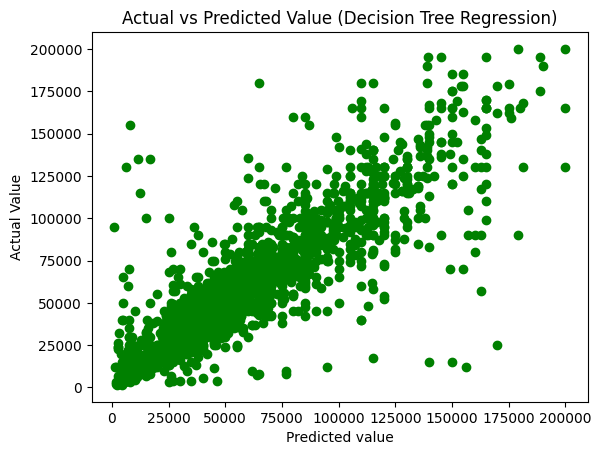

In [85]:
plt.scatter(decision_tree_regressor.predict(X_test),Y_test, color = 'green')  
plt.title('Actual vs Predicted Value (Decision Tree Regression)')  
plt.xlabel('Predicted value') 
plt.ylabel('Actual Value') 
plt.show() 

In [86]:
{"R-Squared 'Higher is better': ":decision_tree_regressor.score(X_test,Y_test),"Mean Squared Error (MSE) 'Lower is better': ":round(mean_squared_error(Y_test,decision_tree_regressor.predict(X_test)))}

{"R-Squared 'Higher is better': ": 0.7051171612929944,
 "Mean Squared Error (MSE) 'Lower is better': ": 404091073}

##### Now let's see what other algorithms have

#### K-Nearest Neighbors (kNN)

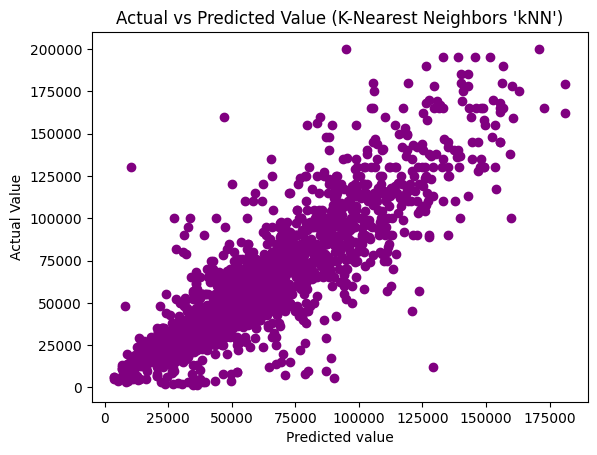

{"R-Squared 'Higher is better': ": 0.7537686823659002,
 "Mean Squared Error (MSE) 'Lower is better': ": 337421729}

In [87]:
kNN_regressor = KNeighborsRegressor(n_neighbors=5)
kNN_regressor.fit(X_train,Y_train)

plt.scatter(kNN_regressor.predict(X_test),Y_test, color = 'purple')  
plt.title("Actual vs Predicted Value (K-Nearest Neighbors 'kNN')")  
plt.xlabel('Predicted value') 
plt.ylabel('Actual Value') 
plt.show() 

{"R-Squared 'Higher is better': ":kNN_regressor.score(X_test,Y_test),"Mean Squared Error (MSE) 'Lower is better': ":round(mean_squared_error(Y_test,kNN_regressor.predict(X_test)))}

#### I've talked about two approaches at the beginning, the sperate Brand and Model, and the combined Brand and Model, here are the results:

#### The sperate Brand and Model approach resulted in:

##### Here is the "kNN Model" with
##### R-Squared: 0.7537, Mean Squared Error (MSE): 337,421,729
##### compared to the "Decision Tree" with 
##### R-Squared: 0.7051, Mean Squared Error (MSE): 404,091,073

#### The Combined Brand_Model Approach resulted in:

##### Here is the "kNN Model" with 
##### R-Squared: 0.7323, Mean Squared Error: 366,758,330
##### compared to the "Decision Tree" with 
##### R-Squared: 0.6860, Mean Squared Error (MSE): 430,189,280

### The Winner is the"kNN Model" from the seperate Brand,Model Approach, and that's what we're going to use in the microservice.

#### Now let's export the kNN Model to use it in the microservice

In [88]:
kNN_pickle_file = "kNN_regression_model.pkl"  

with open(kNN_pickle_file, 'wb') as file:  
    pickle.dump(kNN_regressor, file)